### PREPARATION

In [323]:
import yaml
import logging
import pypsa
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString
import pandas as pd
from pathlib import Path
import seaborn as sns
from datetime import datetime
from cartopy import crs as ccrs
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import os
import xarray as xr
import cartopy
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import sys
import matplotlib.lines as mlines
from matplotlib.patches import Wedge
from matplotlib.ticker import FuncFormatter


In [ ]:
logging.getLogger("pypsa.io").setLevel(logging.ERROR)
warnings.simplefilter(action='ignore', category=ResourceWarning)

# Load the UHS and woUHS networks
# uhs = pypsa.Network("../../../pypsa-earth/results/UHSwoexport/postnetworks/elec_s_24_ec_lcopt_Co2L0.15_3H_2050_0.094_NZ_0export.nc")
# woUHS = pypsa.Network("../../../pypsa-earth/results/woUHSwoexport/postnetworks/elec_s_24_ec_lcopt_Co2L0.15_3H_2050_0.094_NZ_0export.nc")
uhs = pypsa.Network("../../../pypsa-earth/results/UHS/postnetworks/elec_s_24_ec_lcopt_Co2L0.15_3H_2050_0.094_NZ_199.8export.nc")
woUHS = pypsa.Network("../../../pypsa-earth/results/woUHS/postnetworks/elec_s_24_ec_lcopt_Co2L0.15_3H_2050_0.094_NZ_199.8export.nc")

# Load geographic data for onshore regions and ports
regions_onshore = gpd.read_file("../../../pypsa-earth/resources/shapes/country_shapes.geojson")
ports = pd.read_csv("../../../pypsa-earth/resources/UHS/ports.csv")

# Create a GeoDataFrame for ports with point geometries
ports = gpd.GeoDataFrame(
    ports,
    geometry=gpd.points_from_xy(ports["x"], ports["y"]),
    crs="EPSG:4326"  # Coordinates are in WGS84
)

# Load GADM shapes and configuration file
gadm_shapes = gpd.read_file("../../../pypsa-earth/resources/shapes/gadm_shapes.geojson")
config = yaml.safe_load(open("../../../pypsa-earth/config.yaml"))

# Define paths for network and renewable profiles
network_path = "../../../pypsa-earth/networks/UHS/elec.nc"
solar_path = "../../../pypsa-earth/resources/UHS/renewable_profiles/profile_solar.nc"
onwind_path = "../../../pypsa-earth/resources/UHS/renewable_profiles/profile_onwind.nc"

# Get the bounding box for the onshore regions
country_coordinates = regions_onshore.total_bounds[[0, 2, 1, 3]]

# Define colors for scenarios
SCENARIO_COLORS = {"UHS": "#1f77b4", "woUHS": "#ff7f0e"}
tech_colors = config["plotting"]["tech_colors"]

# Normalize the carrier column/index to lowercase for easier matching
def get_color(carrier):
    # First, check for an exact match
    if carrier in tech_colors:
        return tech_colors[carrier]
    # Try matching with lowercase
    if carrier.lower() in tech_colors:
        return tech_colors[carrier.lower()]
    # Default color if no match is found
    return "lightgrey"

# Map colors to carriers in the UHS network
uhs.carriers["color"] = uhs.carriers.index.map(get_color)
woUHS.carriers["color"] = woUHS.carriers.index.map(get_color)

warnings.simplefilter(action='default', category=ResourceWarning)

In [ ]:
# uhs1 = pypsa.Network("results/UHS1/postnetworks/elec_s_1_ec_lcopt_Co2L0.15-3h_3h_2050_0.094_NZ_199.8export.nc")
# woUHS1 = pypsa.Network("results/woUHS1/postnetworks/elec_s_1_ec_lcopt_Co2L0.15_3H_2050_0.094_NZ_199.8export.nc")
# uhs10 = pypsa.Network("results/UHS10/postnetworks/elec_s_10_ec_lcopt_Co2L0.15-3h_3h_2050_0.094_NZ_199.8export.nc")
# woUHS10 = pypsa.Network("results/woUHS10/postnetworks/elec_s_10_ec_lcopt_Co2L0.15_3H_2050_0.094_NZ_199.8export.nc")
# uhs100 = pypsa.Network("results/UHS100/postnetworks/elec_s_100_ec_lcopt_Co2L0.15-3h_3h_2050_0.094_NZ_199.8export.nc")
# woUHS100 = pypsa.Network("results/woUHS100/postnetworks/elec_s_100_ec_lcopt_Co2L0.15_3H_2050_0.094_NZ_199.8export.nc")
# uhswotm = pypsa.Network("results/UHSwotm/postnetworks/elec_s_24_ec_lcopt_Co2L0.15-3h_3h_2050_0.094_NZ_199.8export.nc")
# woUHSwotm = pypsa.Network("results/woUHSwotm/postnetworks/elec_s_24_ec_lcopt_Co2L0.15_3H_2050_0.094_NZ_199.8export.nc")

#### Show initial energy system design

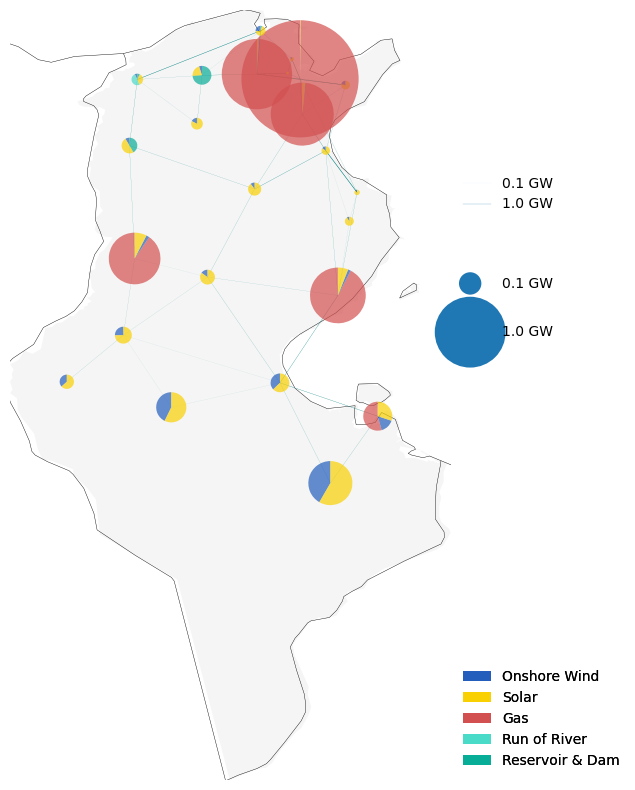

In [ ]:
warnings.simplefilter(action='ignore', category=UserWarning)

# -----------------------------
# Carrier mapping (IMPORTANT)
# -----------------------------
CARRIER_AGG_MAP = {
    "CCGT": "gas",   # Combined-Cycle Gas -> gas
}

def map_carrier(c):
    return CARRIER_AGG_MAP.get(c, c)

# -----------------------------
# Ensure all carriers have color and nice_name
# -----------------------------
missing_carriers = [
    'lignite', 'coal', 'solar rooftop', 'oil', 'gas',
    'residential rural solar thermal',
    'residential urban decentral solar thermal',
    'services rural solar thermal',
    'services urban decentral solar thermal',
    'urban central solar thermal',
    'CCGT'
]

carrier_color_mapping = {
    'lignite': 'coal',
    'solar rooftop': 'solar',
    'residential rural solar thermal': 'solar',
    'residential urban decentral solar thermal': 'solar',
    'services rural solar thermal': 'solar',
    'services urban decentral solar thermal': 'solar',
    'urban central solar thermal': 'solar',
    'CCGT': 'gas'
}


def apply_carrier_styling(n, missing_carriers, carrier_color_mapping):
    # create rows if missing
    for c in missing_carriers:
        if c not in n.carriers.index:
            n.carriers.loc[c, :] = np.nan

    # colors
    for c, ref in carrier_color_mapping.items():
        if ref in n.carriers.index and pd.notna(n.carriers.loc[ref, "color"]):
            n.carriers.loc[c, "color"] = n.carriers.loc[ref, "color"]
        else:
            n.carriers.loc[c, "color"] = "gray"

    # nice_names
    if "coal" in n.carriers.index:
        n.carriers.loc["coal", "nice_name"] = "Coal"
    if "oil" in n.carriers.index:
        n.carriers.loc["oil", "nice_name"] = "Oil"
    if "gas" in n.carriers.index:
        n.carriers.loc["gas", "nice_name"] = "Gas"
    if "CCGT" in n.carriers.index:
        # still exists as a carrier, but will be aggregated to 'gas'
        n.carriers.loc["CCGT", "nice_name"] = "Gas"

    for c, ref in carrier_color_mapping.items():
        if c != "CCGT" and ref in n.carriers.index:
            n.carriers.loc[c, "nice_name"] = n.carriers.loc[ref, "nice_name"]

    # fallbacks
    n.carriers["color"] = n.carriers["color"].replace("", np.nan).fillna("gray")
    n.carriers["nice_name"] = (
        n.carriers["nice_name"]
        .replace("", np.nan)
        .fillna(pd.Series(n.carriers.index, index=n.carriers.index))
    )

    # remove load shedding
    for cand in ["load shedding", "Load shedding"]:
        if cand in n.carriers.index:
            n.carriers.drop(cand, inplace=True)

# Apply to both
apply_carrier_styling(uhs, missing_carriers, carrier_color_mapping)
apply_carrier_styling(woUHS, missing_carriers, carrier_color_mapping)

# -----------------------------
# Scale settings
# -----------------------------
bus_scale = 6e3
line_scale = 6e3
bus_sizes = [100, 1000]   # MW
line_sizes = [100, 1000]  # MW

# -----------------------------
# Aggregate generator and storage capacities by bus and *aggregated* carrier
# -----------------------------
gen = uhs.generators[uhs.generators.carrier != "load shedding"].copy()
gen["carrier_agg"] = gen["carrier"].map(map_carrier)
gen = gen.groupby(["bus", "carrier_agg"]).p_nom.sum()

sto = uhs.storage_units.copy()
sto["carrier_agg"] = sto["carrier"].map(map_carrier)
sto = sto.groupby(["bus", "carrier_agg"]).p_nom.sum()

buses = pd.concat([gen, sto])

# -----------------------------
# Plotting
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Filter Links: only those that lie within GADM regions
link_bus0_base = uhs.links.bus0.str.split("_AC").str[0]
link_bus1_base = uhs.links.bus1.str.split("_AC").str[0]

valid_links = uhs.links[
    link_bus0_base.isin(gadm_shapes.index) &
    link_bus1_base.isin(gadm_shapes.index) &
    (uhs.links.p_nom > 0)
]

links_backup = uhs.links
uhs.links = valid_links

with plt.rc_context({"patch.linewidth": 0.}):
    uhs.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=uhs.lines.s_nom / line_scale,
        link_widths=uhs.links.p_nom / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )

regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)

ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])

# -----------------------------
# Legends
# -----------------------------
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)

# Carrier legend: build from carriers actually used after aggregation
used_carriers_agg = buses.index.get_level_values(1).unique()

colors_legend = []
labels_legend = []
seen = set()

for c in used_carriers_agg:
    # use aggregated carrier's style (e.g., 'gas' not 'CCGT')
    if c in uhs.carriers.index:
        name = uhs.carriers.loc[c, 'nice_name']
        color = uhs.carriers.loc[c, 'color']
    else:
        name = str(c)
        color = "gray"

    val_total = buses.xs(c, level=1).sum() if c in used_carriers_agg else 0

    if name not in seen and val_total > 0:
        seen.add(name)
        colors_legend.append(color)
        labels_legend.append(name)

add_legend_patches(
    ax,
    colors_legend,
    labels_legend,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc": "lower left"},
)

fig.tight_layout()
plt.show()

# Restore original links
uhs.links = links_backup
warnings.simplefilter(action='default', category=UserWarning)


#### Current Capacities of Energy Carriers and Usage of Storages

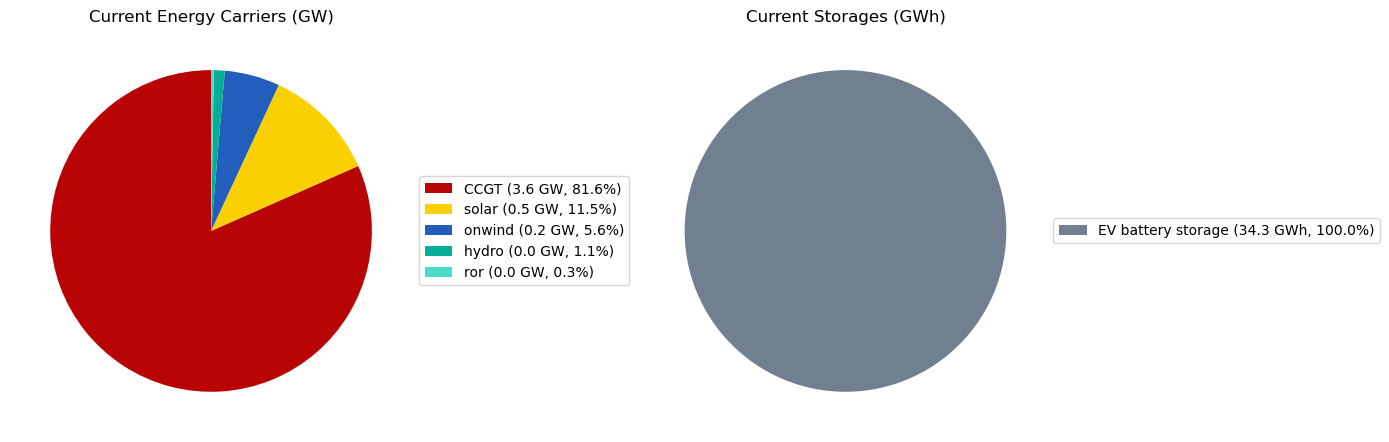

In [ ]:
# --- Extract data for current energy carriers ---
energy_carriers = pd.concat([uhs.generators[~uhs.generators.carrier.str.contains("load", case=False)][["carrier", "p_nom"]], uhs.storage_units[["carrier", "p_nom"]]]).groupby("carrier").p_nom.sum().div(1e3).sort_values(ascending=False)


# --- Extract data for current storages ---
storages = (
    uhs.stores.groupby("carrier")
    .e_nom.sum()
    .div(1e3)  # Convert to GWh
    .sort_values(ascending=False)
)

# --- Filter: keep only entries > 0 ---
energy_carriers = energy_carriers[energy_carriers > 0]
storages = storages[storages > 0]
storages = storages[~storages.index.isin(["solid biomass", "biogas"])]

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# --- Energy carriers ---
energy_colors = [get_color(c) for c in energy_carriers.index]
wedges1, _ = axes[0].pie(
    energy_carriers,
    labels=None,   # no labels directly in the chart
    startangle=90,
    colors=energy_colors
)
axes[0].set_title("Current Energy Carriers (GW)")

# Legend with capacity + share
labels1 = [
    f"{c} ({v:.1f} GW, {100*v/energy_carriers.sum():.1f}%)"
    for c, v in zip(energy_carriers.index, energy_carriers.values)
]
axes[0].legend(
    wedges1,
    labels1,
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

# --- Storages ---
storage_colors = [get_color(c) for c in storages.index]
wedges2, _ = axes[1].pie(
    storages,
    labels=None,
    startangle=90,
    colors=storage_colors
)
axes[1].set_title("Current Storages (GWh)")

# Legend with capacity + share
labels2 = [
    f"{c} ({v:.1f} GWh, {100*v/storages.sum():.1f}%)"
    for c, v in zip(storages.index, storages.values)
]
axes[1].legend(
    wedges2,
    labels2,
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.tight_layout()
plt.show()


#### Where is it possible to build UHS in salt caverns?

In [ ]:
def extract_uhs_regions(n, gadm_shapes):
    """
    Extract UHS storage regions and capacities and merge them with GADM shapes.

    Parameters
    ----------
    n : PyPSA Network
        The network containing UHS storage units in uhs.stores.
    gadm_shapes : GeoDataFrame
        GADM regions with column 'GADM_ID' for merging.

    Returns
    -------
    GeoDataFrame
        GADM shapes enriched with:
        - 'Capacity': summed UHS capacity per region
        - 'UHS': boolean flag if region has UHS
    """

    # Filter UHS stores
    n_stores = n.stores[n.stores.carrier == "H2 UHS"].copy()

    # Extract region name from store index
    n_stores["region"] = n_stores.index.str.split("_AC").str[0]

    # Summed installed capacity (MW) by region
    n_capacity = (
        n_stores.groupby("region")["e_nom_opt"]
        .sum()
        .reset_index()
        .rename(columns={"e_nom_opt": "Capacity"})
    )

    # Merge with GADM shapes
    n_gadm = gadm_shapes.merge(
        n_capacity,
        how="left",
        left_on="GADM_ID",
        right_on="region"
    )

    # Mark regions that have UHS
    n_regions = n_stores["region"].unique()
    n_gadm["UHS"] = n_gadm["GADM_ID"].isin(n_regions)

    return n_gadm

uhs_gadm = extract_uhs_regions(uhs, gadm_shapes)
woUHS_gadm = extract_uhs_regions(woUHS, gadm_shapes)

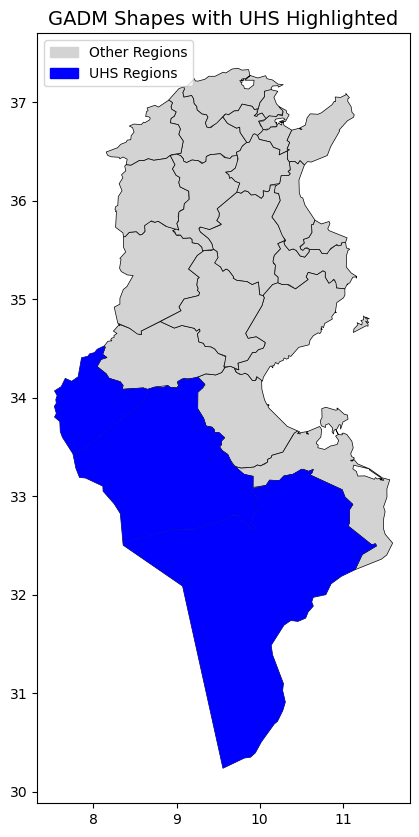

In [ ]:
# Plot the map
fig, ax = plt.subplots(figsize=(12, 10))
uhs_gadm.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5)

# Highlight regions with UHS
if not uhs_gadm[uhs_gadm["UHS"]].empty:
    uhs_gadm[uhs_gadm["UHS"]].plot(ax=ax, color="blue", label="UHS Regions")

# Add legend and title
blue_patch = mpatches.Patch(color='blue', label='UHS Regions')
grey_patch = mpatches.Patch(color='lightgrey', label='Other Regions')
ax.legend(handles=[grey_patch, blue_patch], loc="upper left")
ax.set_title("GADM Shapes with UHS Highlighted", fontsize=14)
plt.show()

Text(0, 0.5, 'Stored Energy [MWh$_{H_2}$]')

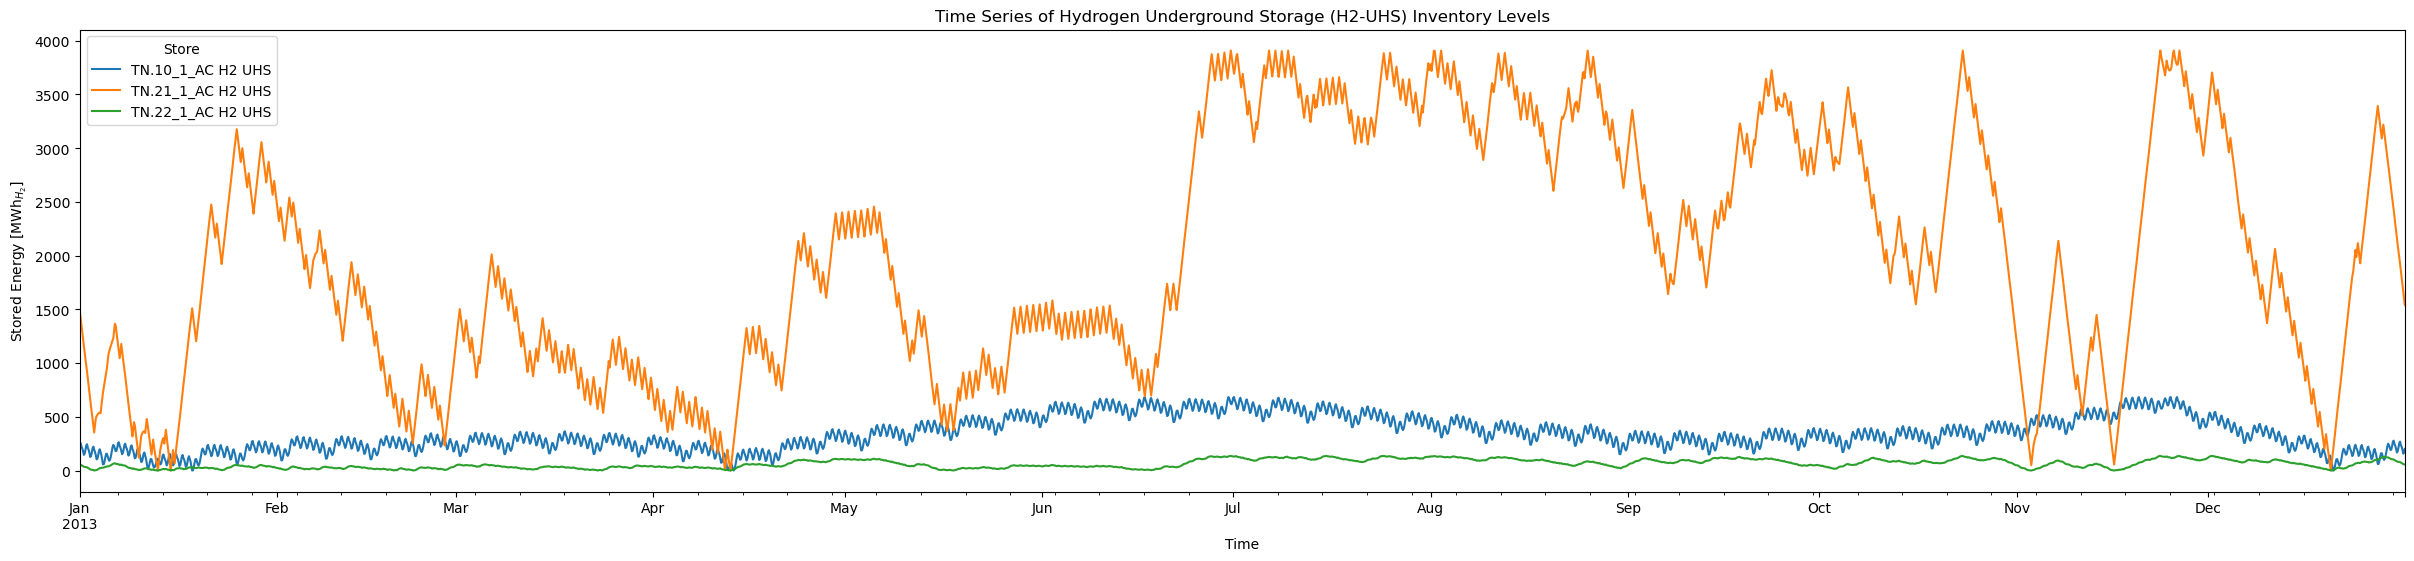

In [ ]:
ax = uhs.stores_t.e.loc[:, uhs.stores[uhs.stores.carrier == "H2 UHS"].index] \
    .plot(figsize=(30, 6))

ax.set_title("Time Series of Hydrogen Underground Storage (H2-UHS) Inventory Levels")
ax.set_xlabel("Time")
ax.set_ylabel("Stored Energy [MWh$_{H_2}$]")


#### Which hydrogen infrastructure does the model have in 2050?

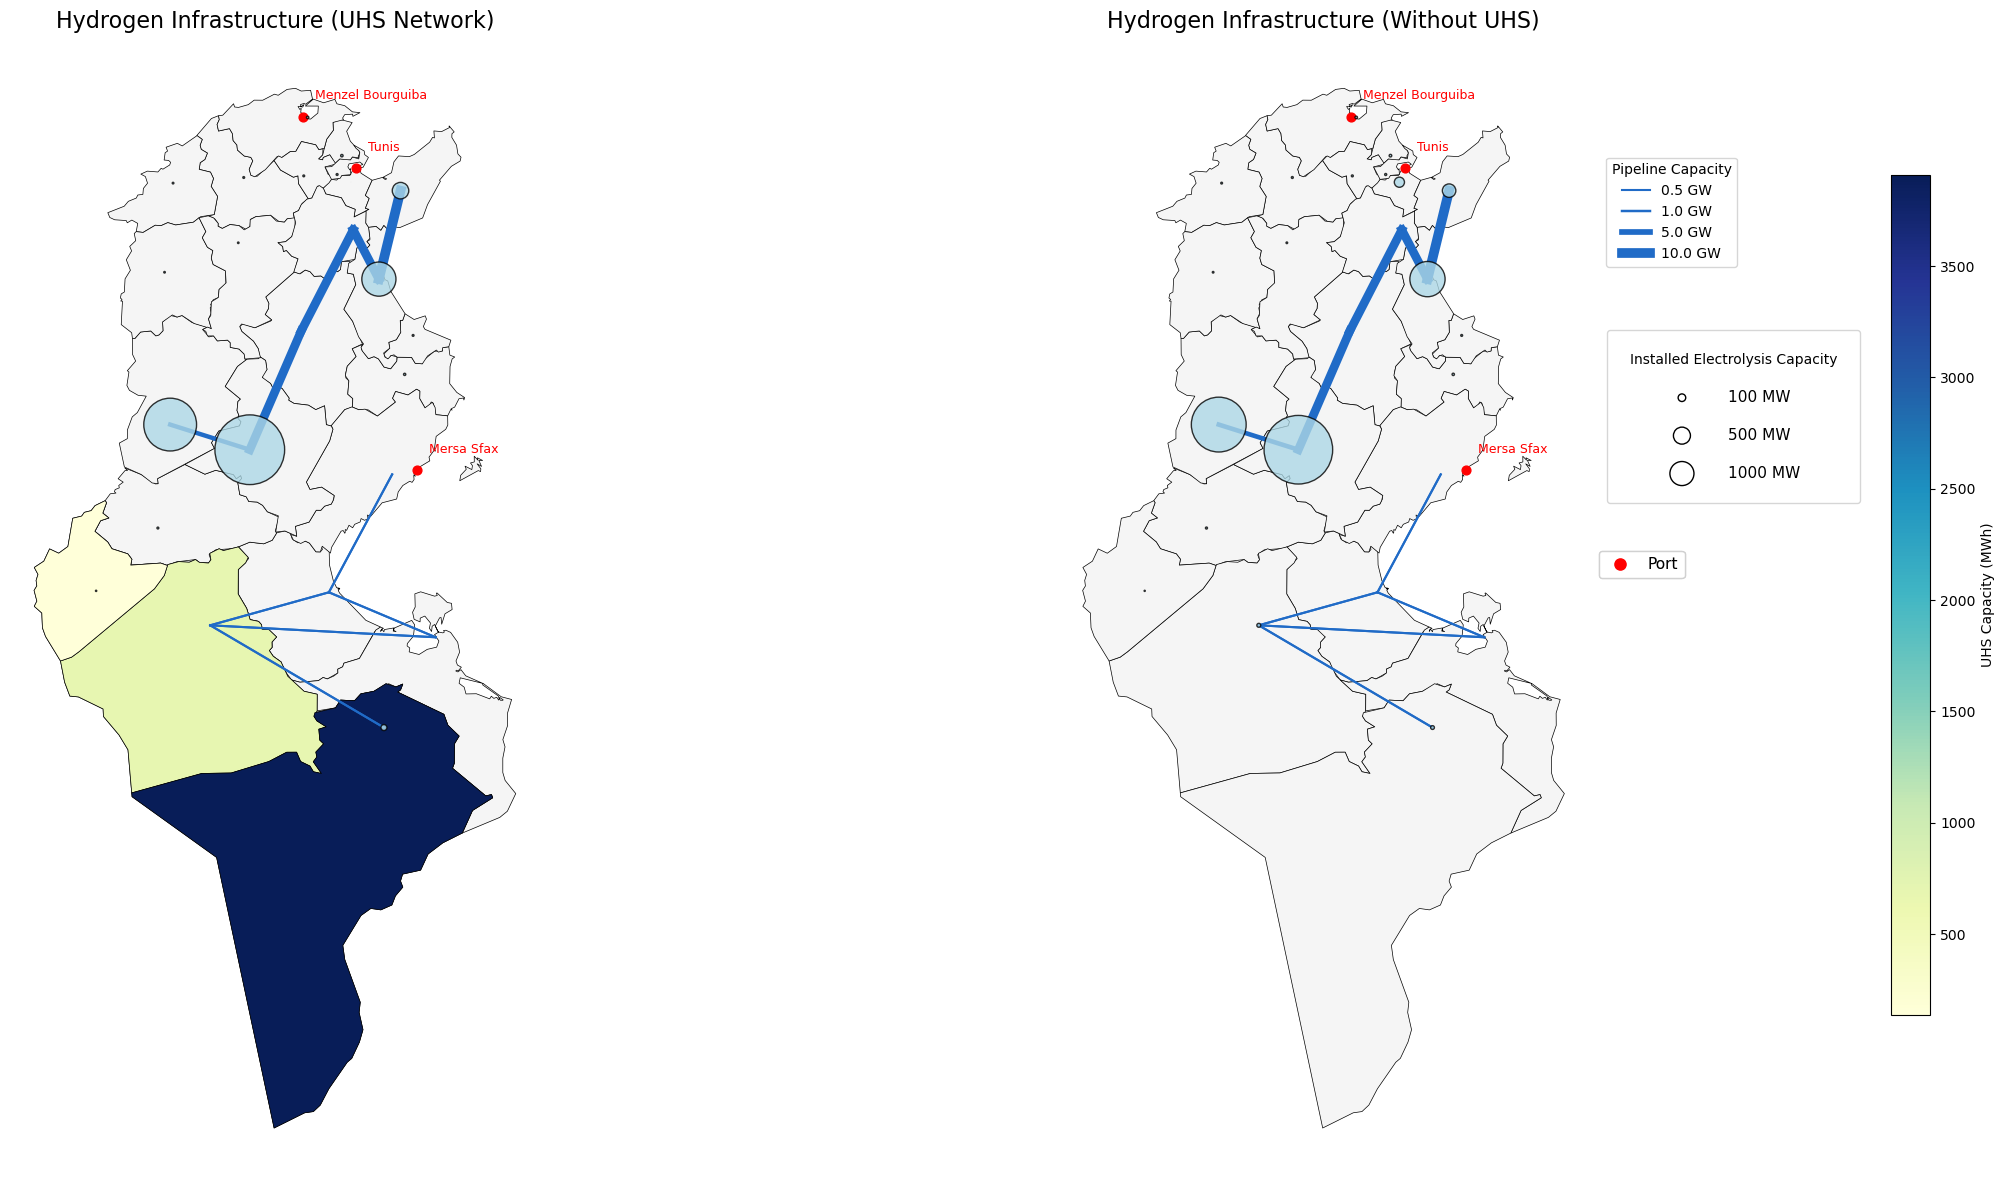

In [ ]:
# --- Select, what should be shown ---
show_uhs = True
show_ports = True
show_pipelines = True
show_electrolyzers = True
show_woUHS = True

size_factor = 0.3

warnings.simplefilter(action='ignore')

def plot_infrastructure(ax, gadm, net, ports, show_uhs, show_pipelines,
                        show_electrolyzers, show_ports):
    """
    Draws the full hydrogen infrastructure on a given axis.

    Parameters
    ----------
    ax : matplotlib axis
        The axis to draw on.
    gadm : GeoDataFrame
        Regional shapes (uhs_gadm or woUHS_gadm).
    net : PyPSA network
        The network used for plotting (uhs or woUHS).
    ports : GeoDataFrame
        Port locations.
    show_uhs : bool
        Whether to show UHS capacities.
    show_pipelines : bool
        Whether to show pipelines.
    show_electrolyzers : bool
        Whether to show electrolyzers.
    show_ports : bool
        Whether to show ports.
    """

    # --- Base map ---
    gadm.plot(ax=ax, color="whitesmoke", edgecolor="black", linewidth=0.5)

    # --- UHS Capacities ---
    if show_uhs and "Capacity" in gadm.columns:
        gadm.dropna(subset=["Capacity"]).plot(
            ax=ax,
            column="Capacity",
            cmap="YlGnBu",
            edgecolor="black",
            linewidth=0.5,
            legend=False
        )

    # --- Pipelines ---
    if show_pipelines:
        h2_pipelines = net.links[net.links.carrier.str.contains("H2 pipeline", case=False, na=False)]

        if not h2_pipelines.empty:  # <-- check if there are pipelines
            # Build pipeline geometries
            def build_pipeline_geometry(row):
                x0, y0 = net.buses.loc[row.bus0, ["x", "y"]]
                x1, y1 = net.buses.loc[row.bus1, ["x", "y"]]
                return LineString([(x0, y0), (x1, y1)])

            pipelines = h2_pipelines.copy()
            pipelines["geometry"] = pipelines.apply(build_pipeline_geometry, axis=1)

            lines_gdf = gpd.GeoDataFrame(pipelines, geometry="geometry", crs="EPSG:4326")

            if "p_nom_opt" in lines_gdf.columns:
                capacity = lines_gdf["p_nom_opt"]
                widths = np.interp(capacity, (capacity.min(), capacity.max()), (1.5, 7.0))
            else:
                widths = [1.5] * len(lines_gdf)

            # Draw pipelines
            for geom, w in zip(lines_gdf.geometry, widths):
                ax.plot(*geom.xy, color="#206bc7", linewidth=w, zorder=2)
        else:
            # No pipelines in this network, skip
            pass
        
    # --- Electrolyzers ---
    if show_electrolyzers:
    # Select electrolyzer links
        electrolysis_links = net.links[net.links.carrier == "H2 Electrolysis"]

        if not electrolysis_links.empty:
            # Installed capacity per link [MW]
            p_nom = electrolysis_links["p_nom_opt"]

            # Aggregate by bus (typically bus0)
            bus_map = electrolysis_links.bus0
            p_nom_by_bus = p_nom.groupby(bus_map).sum()  # [MW]

            # Coordinates
            coords = net.buses.loc[p_nom_by_bus.index, ["x", "y"]]

            # Visual scaling only
            sizes = p_nom_by_bus * size_factor

            ax.scatter(
                coords["x"], coords["y"],
                s=sizes,
                c="lightblue",
                alpha=0.8,
                edgecolor="k",
                zorder=3
            )

    # --- Ports ---
    if show_ports:
        # Select ports inside the region shapes
        ports_within = gpd.sjoin(ports, gadm, how="inner", predicate="within")
        ports_within.plot(ax=ax, color="red", markersize=40, marker="o")

        # Draw port labels
        for x, y, name in zip(ports_within.geometry.x,
                              ports_within.geometry.y,
                              ports_within["name"]):
            ax.annotate(name, (x + 0.1, y + 0.1),
                        fontsize=9, color="red", ha="left", va="bottom")

    ax.set_axis_off()

# --- AUTOMATIC: one or two subplots ---
if show_woUHS:
    fig, axes = plt.subplots(1, 2, figsize=(26, 12))
    ax_left = axes[0]
    ax_right = axes[1]

    # --- LEFT PANEL: UHS network ---
    plot_infrastructure(
        ax_left, uhs_gadm, uhs, ports,
        show_uhs, show_pipelines, show_electrolyzers, show_ports
    )
    ax_left.set_title("Hydrogen Infrastructure (UHS Network)", fontsize=16)

    # --- RIGHT PANEL: network without UHS ---
    plot_infrastructure(
        ax_right, woUHS_gadm, woUHS, ports,
        False, show_pipelines, show_electrolyzers, show_ports
    )
    ax_right.set_title("Hydrogen Infrastructure (Without UHS)", fontsize=16)

else:
    # Single plot case
    fig, ax = plt.subplots(figsize=(14, 12))
    plot_infrastructure(
        ax, uhs_gadm, uhs, ports,
        show_uhs, show_pipelines, show_electrolyzers, show_ports
    )
    ax.set_title("Hydrogen Infrastructure", fontsize=16)

# --- Determine global min/max pipeline capacity from both networks ---
def get_pipeline_caps(net):
    df = net.links[net.links.carrier.str.contains("H2 pipeline", case=False, na=False)]
    if df.empty:
        return []
    return df["p_nom_opt"].values

all_caps = np.concatenate([
    get_pipeline_caps(uhs),
    get_pipeline_caps(woUHS)
]) if show_woUHS else get_pipeline_caps(uhs)

if len(all_caps) > 0:
    min_cap = all_caps.min()
    max_cap = all_caps.max()
else:
    min_cap, max_cap = 1, 10


# --- starting y-position for legends
legend_y = 0.9
spacing = 0.11

# Pipeline legend
if show_pipelines:
    legend_caps = [500, 1000, 5000, 10000]
    min_cap, max_cap = min(legend_caps), max(legend_caps)
    legend_widths = np.interp(legend_caps, (min_cap, max_cap), (1.5, 7.0))
    pipeline_handles = [
        mlines.Line2D([], [], color="#206bc7", linewidth=w, label=f"{cap/1000:.1f} GW")
        for cap, w in zip(legend_caps, legend_widths)
    ]
    leg1 = axes[1].legend(handles=pipeline_handles, title="Pipeline Capacity",
                           loc="upper left", bbox_to_anchor=(1.02, legend_y), fontsize=10)
    fig.add_artist(leg1)
    legend_y -= spacing

# Electrolyzer legend
if show_electrolyzers:
    example_caps = [100, 500, 1000]  # MW
    example_sizes = [c * size_factor for c in example_caps]

    bubble_handles = [
        plt.scatter([], [], s=s, facecolors="none", edgecolors="k",
                    label=f"{cap} MW")
        for s, cap in zip(example_sizes, example_caps)
    ]

    leg2 = axes[1].legend(
        handles=bubble_handles,
        title="Installed Electrolysis Capacity",
        loc="upper left",
        bbox_to_anchor=(1.02, 0.75),
        fontsize=11,
        scatterpoints=1,
        handletextpad=2,
        borderpad=1.5,
        labelspacing=1.5
    )

    fig.add_artist(leg2)
    legend_y -= spacing

   

# Ports legend
if show_ports:
    port_handle = [mlines.Line2D([], [], color="red", marker="o", linestyle="None",
                                 markersize=8, label="Port")]
    leg3 = axes[1].legend(handles=port_handle,
        loc="upper left",
        bbox_to_anchor=(1.02, 0.55),
        borderaxespad=0,
        fontsize=11)
    fig.add_artist(leg3)
    legend_y -= spacing

# UHS colorbar
if show_uhs and "Capacity" in uhs_gadm.columns and not uhs_gadm["Capacity"].dropna().empty:
    import matplotlib as mpl
    cmap = mpl.cm.YlGnBu
    norm = mpl.colors.Normalize(vmin=uhs_gadm["Capacity"].min(),
                               vmax=uhs_gadm["Capacity"].max())
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Create a new axes for the colorbar on the right side
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label("UHS Capacity (MWh)")


plt.tight_layout()
plt.show()

#### Compare energy system with uhs and without

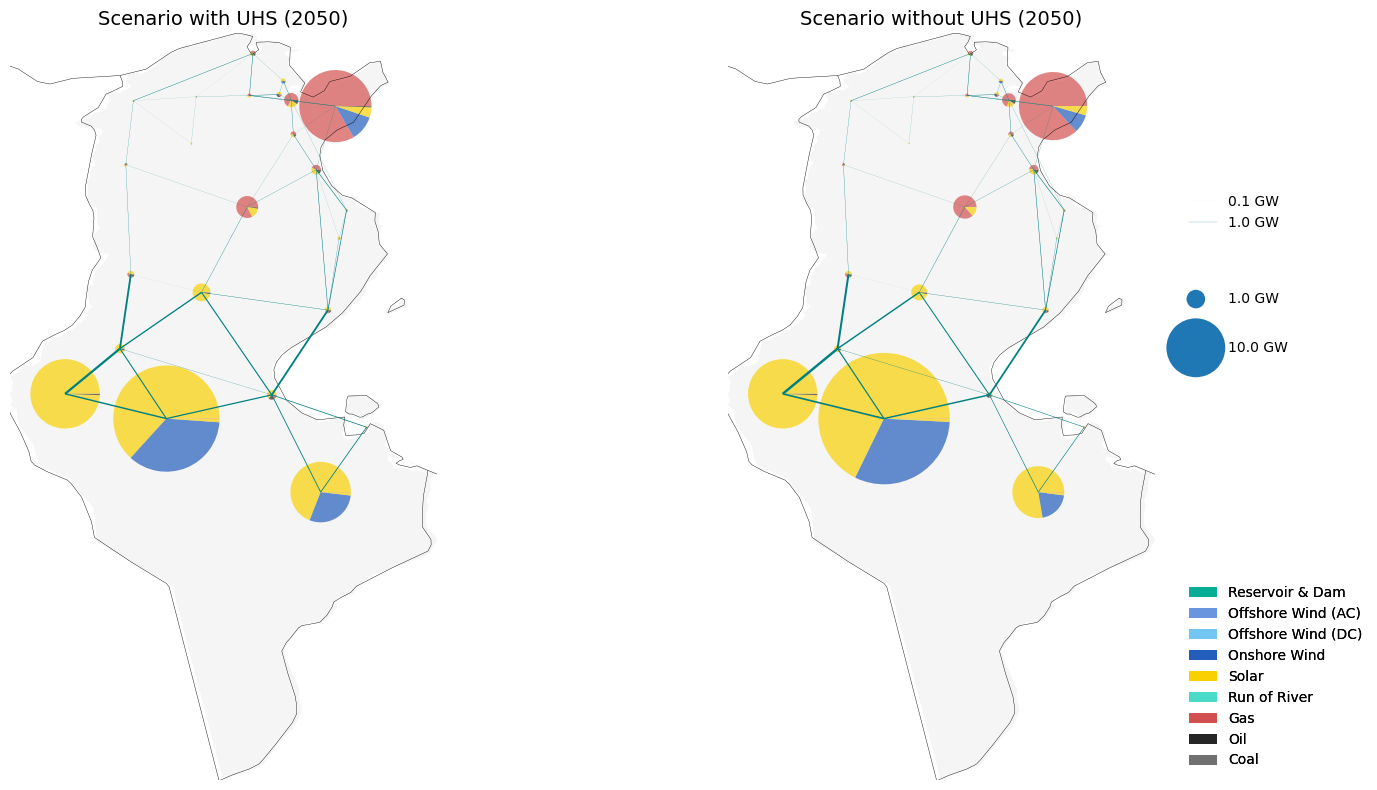

In [ ]:
warnings.simplefilter(action="ignore", category=UserWarning)

# -----------------------------
# Carrier preparation (colors + nice_name)
# -----------------------------
carrier_color_mapping = {
    "lignite": "coal",
    "solar rooftop": "solar",
    "residential rural solar thermal": "solar",
    "residential urban decentral solar thermal": "solar",
    "services rural solar thermal": "solar",
    "services urban decentral solar thermal": "solar",
    "urban central solar thermal": "solar",
    "ccgt": "gas",
}

CARRIER_AGG_MAP = {
    "CCGT": "gas",   # Combined-Cycle Gas -> gas
}

def prepare_carriers(n):
    n = n.copy()

    if "color" not in n.carriers.columns:
        n.carriers["color"] = np.nan
    if "nice_name" not in n.carriers.columns:
        n.carriers["nice_name"] = n.carriers.index

    for c, ref in carrier_color_mapping.items():
        if c not in n.carriers.index:
            n.carriers.loc[c, ["color", "nice_name"]] = [np.nan, c.replace("_", " ").capitalize()]

        if ref in n.carriers.index and pd.notna(n.carriers.loc[ref, "color"]) and n.carriers.loc[ref, "color"] != "":
            n.carriers.loc[c, "color"] = n.carriers.loc[ref, "color"]
        else:
            n.carriers.loc[c, "color"] = "gray"

        if c != "ccgt" and ref in n.carriers.index and pd.notna(n.carriers.loc[ref, "nice_name"]):
            n.carriers.loc[c, "nice_name"] = n.carriers.loc[ref, "nice_name"]

    if "coal" in n.carriers.index:
        n.carriers.loc["coal", "nice_name"] = "Coal"
    if "oil" in n.carriers.index:
        n.carriers.loc["oil", "nice_name"] = "Oil"
    if "gas" in n.carriers.index:
        n.carriers.loc["gas", "nice_name"] = "Gas"
    if "ccgt" in n.carriers.index:
        n.carriers.loc["ccgt", "nice_name"] = "Gas"
        if (pd.isna(n.carriers.loc["ccgt", "color"]) or n.carriers.loc["ccgt", "color"] == "") and "gas" in n.carriers.index:
            gcol = n.carriers.loc["gas", "color"]
            if pd.notna(gcol) and gcol != "":
                n.carriers.loc["ccgt", "color"] = gcol

    n.carriers["color"] = n.carriers["color"].replace("", np.nan).fillna("gray")
    n.carriers["nice_name"] = (
        n.carriers["nice_name"]
        .replace("", np.nan)
        .fillna(pd.Series(n.carriers.index, index=n.carriers.index))
    )

    for cand in ["Load shedding", "load shedding"]:
        if cand in n.carriers.index:
            n.carriers = n.carriers.drop(cand)

    return n

# -----------------------------
# Hub mapping via coordinates (generalized)
# -----------------------------
def build_hub_mapping(n, min_cluster_size=2):
    """
    A hub is defined as a coordinate cluster (x,y) that contains at least min_cluster_size buses.
    This automatically excludes global / non-spatial buses that don't share coordinates with others.

    Returns:
      bus_to_hub: Series mapping bus -> hub_id
      hub_coords: DataFrame mapping hub_id -> x,y
    """
    buses_xy = n.buses[["x", "y"]].copy()

    # Ensure numeric and drop missing coordinates
    buses_xy["x"] = pd.to_numeric(buses_xy["x"], errors="coerce")
    buses_xy["y"] = pd.to_numeric(buses_xy["y"], errors="coerce")
    buses_xy = buses_xy.dropna(subset=["x", "y"])

    grouped = buses_xy.groupby(["x", "y"], sort=False)

    bus_to_hub = {}
    hub_coords = {}
    hub_id = 0

    for (x, y), df in grouped:
        if len(df) < min_cluster_size:
            continue
        hid = f"hub_{hub_id}"
        hub_id += 1

        for bus in df.index:
            bus_to_hub[bus] = hid
        hub_coords[hid] = {"x": x, "y": y}

    bus_to_hub = pd.Series(bus_to_hub, dtype="object")
    hub_coords = pd.DataFrame.from_dict(hub_coords, orient="index")

    return bus_to_hub, hub_coords

# -----------------------------
# Aggregation: Generators + StorageUnits by hub & carrier
# -----------------------------
def aggregate_gen_sto_by_hub(n, bus_to_hub):
    parts = []

    if len(n.generators):
        gen = n.generators[n.generators.carrier != "load shedding"].copy()
        gen["hub"] = gen["bus"].map(bus_to_hub)
        gen = gen.dropna(subset=["hub"])

        # <-- entscheidend: carrier für Aggregation mappen
        gen["carrier_agg"] = gen["carrier"].replace(CARRIER_AGG_MAP)

        parts.append(gen.groupby(["hub", "carrier_agg"])["p_nom_opt"].sum())

    if len(n.storage_units):
        sto = n.storage_units.copy()
        sto["hub"] = sto["bus"].map(bus_to_hub)
        sto = sto.dropna(subset=["hub"])

        sto["carrier_agg"] = sto["carrier"].replace(CARRIER_AGG_MAP)

        parts.append(sto.groupby(["hub", "carrier_agg"])["p_nom_opt"].sum())

    if not parts:
        return pd.Series(dtype=float)

    return pd.concat(parts).groupby(level=[0, 1]).sum()

# -----------------------------
# Draw one pie per hub
# -----------------------------
def draw_pies(ax, hubs_caps, hub_coords, carriers_df, bus_scale, alpha=0.7, radius_mode="linear"):
    if hubs_caps.empty or hub_coords.empty:
        return

    hub_totals = hubs_caps.groupby(level=0).sum()

    for hub, total in hub_totals.items():
        if total <= 0 or hub not in hub_coords.index:
            continue

        x, y = hub_coords.loc[hub, ["x", "y"]]

        if radius_mode == "sqrt":
            r = np.sqrt(total / bus_scale)
        else:
            r = total / bus_scale

        s = hubs_caps.xs(hub, level=0)
        s = s[s > 0].sort_values(ascending=False)
        if s.empty:
            continue

        start = 0.0
        denom = s.sum()

        for carrier, val in s.items():
            end = start + (val / denom) * 360.0

            color = "gray"
            if carrier in carriers_df.index and "color" in carriers_df.columns:
                c = carriers_df.loc[carrier, "color"]
                if pd.notna(c) and c != "":
                    color = c

            ax.add_patch(
                Wedge(
                    (x, y), r, start, end,
                    facecolor=color, edgecolor="none", alpha=alpha,
                    transform=ccrs.PlateCarree(),
                )
            )
            start = end

# -----------------------------
# Plot routine: network lines/links via PyPSA, pies drawn manually
# -----------------------------
def plot_network_one_pie_per_location(
    n, ax, title, gadm_shapes, regions_onshore,
    bus_scale, line_scale, min_cluster_size=2, pie_alpha=0.7, pie_radius_mode="linear"
):
    bus_to_hub, hub_coords = build_hub_mapping(n, min_cluster_size=min_cluster_size)
    hubs_caps = aggregate_gen_sto_by_hub(n, bus_to_hub)

    # Suppress PyPSA bus glyphs; we draw pies ourselves
    zero_bus_sizes = pd.Series(0.0, index=n.buses.index)

    # Filter links for plotting ONLY (still excluded from pies)
    link_bus0_base = n.links.bus0.str.split("_AC").str[0]
    link_bus1_base = n.links.bus1.str.split("_AC").str[0]
    valid_links = n.links[
        link_bus0_base.isin(gadm_shapes.index)
        & link_bus1_base.isin(gadm_shapes.index)
        & (n.links.p_nom_opt > 0)
    ]

    n_plot = n.copy()
    n_plot.links = valid_links

    # Background
    regions_onshore.plot(
        ax=ax,
        facecolor="whitesmoke",
        edgecolor="white",
        transform=ccrs.PlateCarree(),
        linewidth=0,
    )

    with plt.rc_context({"patch.linewidth": 0.0}):
        n_plot.plot(
            bus_sizes=zero_bus_sizes,
            bus_alpha=0.0,
            line_widths=n_plot.lines.s_nom_opt / line_scale,
            link_widths=n_plot.links.p_nom_opt / line_scale,
            line_colors="teal",
            ax=ax,
            margin=0.2,
            color_geomap=None,
        )

    ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
    ax.set_title(title, fontsize=14)

    # Pies overlay
    draw_pies(
        ax, hubs_caps, hub_coords, n.carriers,
        bus_scale=bus_scale, alpha=pie_alpha, radius_mode=pie_radius_mode
    )

    # Return used carriers for legend building
    used_carriers = set()
    if len(n.generators):
        used_carriers |= set(n.generators.carrier.replace(CARRIER_AGG_MAP))
    if len(n.storage_units):
        used_carriers |= set(n.storage_units.carrier.replace(CARRIER_AGG_MAP))
    used_carriers.discard("load shedding")
    return used_carriers

# -----------------------------
# USER SETTINGS
# -----------------------------
bus_scale  = 6e4
line_scale = 6e3
bus_sizes_legend  = [1000, 10000]  # MW (legend only)
line_sizes_legend = [100, 1000]      # MW (legend only)

# Pie hub definition:
# - min_cluster_size=2 excludes coordinate singletons (typical global buses)
min_cluster_size = 2

# -----------------------------
# Run (two scenarios side-by-side)
# -----------------------------
uhs_p   = prepare_carriers(uhs)
woUHS_p = prepare_carriers(woUHS)

fig, axes = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={"projection": ccrs.PlateCarree()})

used_0 = plot_network_one_pie_per_location(
    uhs_p, axes[0], "Scenario with UHS (2050)",
    gadm_shapes, regions_onshore,
    bus_scale, line_scale,
    min_cluster_size=min_cluster_size,
    pie_alpha=0.7,
    pie_radius_mode="linear",
)
used_1 = plot_network_one_pie_per_location(
    woUHS_p, axes[1], "Scenario without UHS (2050)",
    gadm_shapes, regions_onshore,
    bus_scale, line_scale,
    min_cluster_size=min_cluster_size,
    pie_alpha=0.7,
    pie_radius_mode="linear",
)

# -----------------------------
# Legends (reuse your helpers)
# -----------------------------
legend_kwargs = {"loc": "upper left", "frameon": False}

add_legend_circles(
    axes[1],
    [s / bus_scale for s in bus_sizes_legend],
    [f"{s / 1000} GW" for s in bus_sizes_legend],
    legend_kw={"bbox_to_anchor": (1.05, 0.67), "labelspacing": 2.5, **legend_kwargs},
)
add_legend_lines(
    axes[1],
    [s / line_scale for s in line_sizes_legend],
    [f"{s / 1000} GW" for s in line_sizes_legend],
    legend_kw={"bbox_to_anchor": (1.05, 0.8), **legend_kwargs},
)

# Carrier legend: union across both scenarios, from generators + storage_units only
used_carriers = {CARRIER_AGG_MAP.get(c, c) for c in used_0.union(used_1)}

colors_legend, labels_legend, seen = [], [], set()
for c in uhs_p.carriers.index:
    if c not in used_carriers:
        continue

    name = uhs_p.carriers.loc[c, "nice_name"] if "nice_name" in uhs_p.carriers.columns else c
    if pd.isna(name) or name == "":
        name = c.replace("_", " ").capitalize()

    color = uhs_p.carriers.loc[c, "color"] if "color" in uhs_p.carriers.columns else "gray"
    if pd.isna(color) or color == "":
        color = "gray"

    if name not in seen:
        seen.add(name)
        colors_legend.append(color)
        labels_legend.append(name)

add_legend_patches(
    axes[1],
    colors_legend,
    labels_legend,
    legend_kw={"bbox_to_anchor": (1.05, 0), **legend_kwargs, "loc": "lower left"},
)

fig.tight_layout()
plt.show()

warnings.simplefilter(action="default", category=UserWarning)

#### Capacity extension of energy carriers

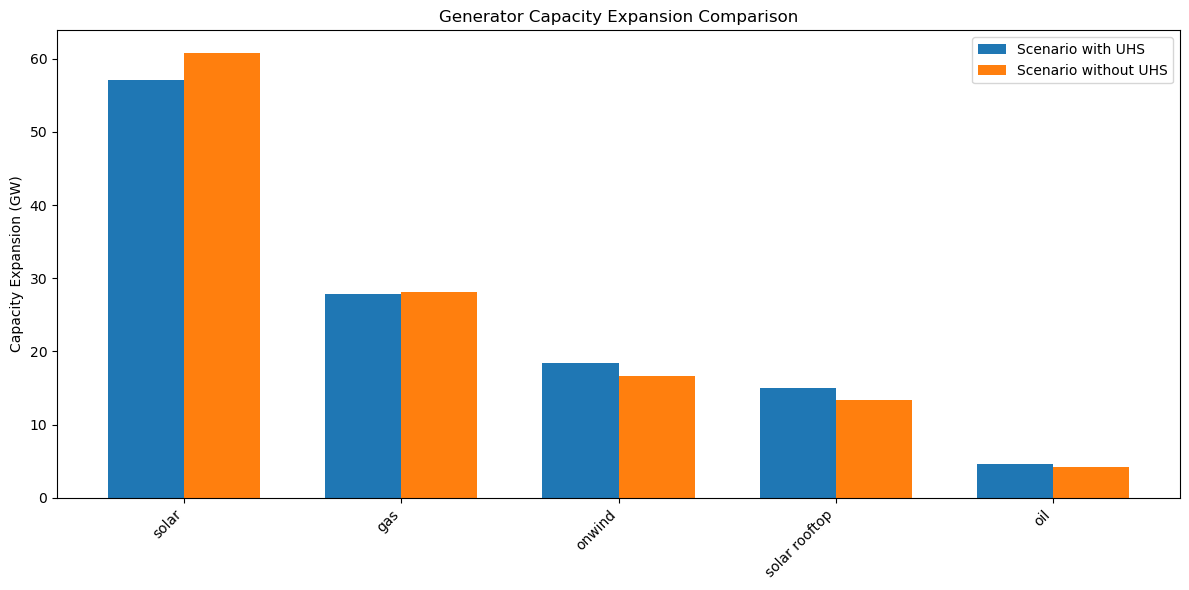

In [ ]:

def generator_capacity_expansion(n, to_gw=True, drop_zeros=True, eps=1e-6):
    """
    Returns Series indexed by carrier with expansion = sum(p_nom_opt - p_nom).
    """
    g = n.generators.copy()

    # p_nom exists for extendable and non-extendable gens; fill missing with 0
    if "p_nom" not in g.columns:
        g["p_nom"] = 0.0
    g["p_nom"] = g["p_nom"].fillna(0.0)

    # Optional: exclude load shedding if present
    g = g[g.carrier != "load shedding"]

    exp = (g["p_nom_opt"] - g["p_nom"]).groupby(g["carrier"]).sum()

    if to_gw:
        exp = exp / 1e3  # MW -> GW

    if drop_zeros:
        exp = exp[exp.abs() > eps]

    return exp.sort_values(ascending=False)

# --- Compute expansions ---
exp_uhs   = generator_capacity_expansion(uhs, to_gw=True, drop_zeros=False)
exp_woUHS = generator_capacity_expansion(woUHS, to_gw=True, drop_zeros=False)

# Align carriers across scenarios
df_expansion = pd.concat(
    [exp_uhs.rename("Scenario with UHS"), exp_woUHS.rename("Scenario without UHS")],
    axis=1
).fillna(0.0)

# (Optional) drop carriers with ~0 in both scenarios
eps = 1e-6
df_expansion = df_expansion[(df_expansion.abs().max(axis=1) > eps)]

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.35
x = np.arange(len(df_expansion.index))

ax.bar(x - width/2, df_expansion["Scenario with UHS"], width, color=SCENARIO_COLORS["UHS"], label="Scenario with UHS")
ax.bar(x + width/2, df_expansion["Scenario without UHS"], width, color=SCENARIO_COLORS["woUHS"], label="Scenario without UHS")

ax.set_xticks(x)
ax.set_xticklabels(df_expansion.index, rotation=45, ha="right")
ax.set_ylabel("Capacity Expansion (GW)")
ax.set_title("Generator Capacity Expansion Comparison")
ax.legend()

plt.tight_layout()
plt.show()


#### Capacity extension of storages

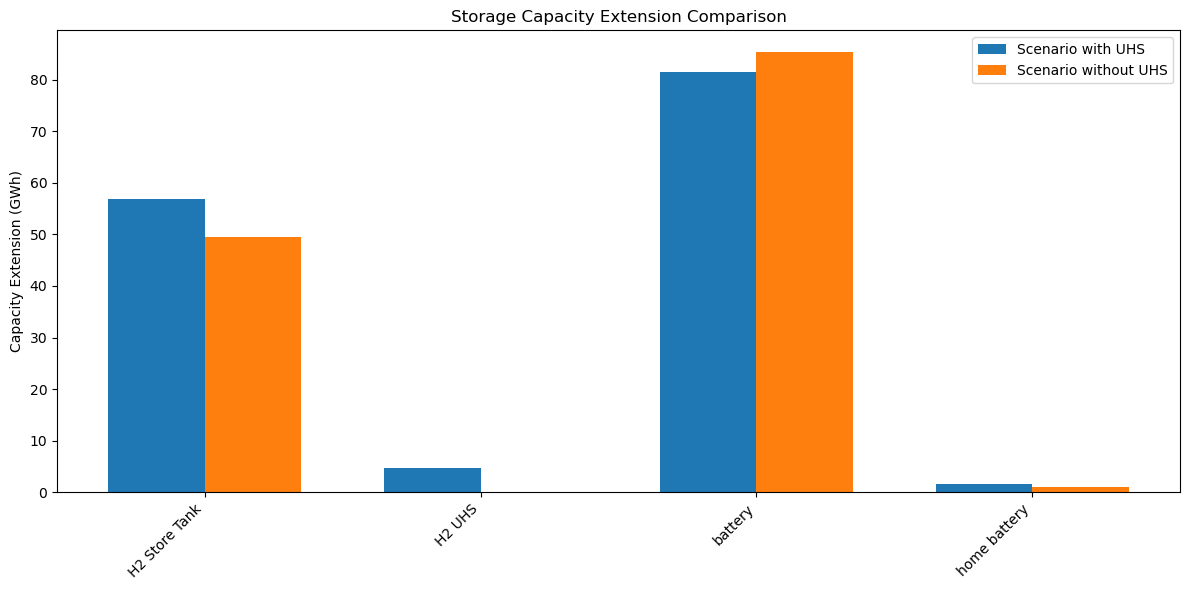

In [ ]:
threshold = 1e-1

def storage_extension_GWh(n):
    stores = n.stores.copy()
    # If e_nom exists, compute added capacity; else fall back to e_nom_opt
    if "e_nom" in stores.columns:
        ext_MWh = (stores["e_nom_opt"] - stores["e_nom"]).clip(lower=0)
    else:
        ext_MWh = stores["e_nom_opt"].fillna(0)
    return ext_MWh.groupby(stores["carrier"]).sum() / 1e3  # GWh

uhs_storage_extension = storage_extension_GWh(uhs)
woUHS_storage_extension = storage_extension_GWh(woUHS)

# --- Filter unwanted carriers ---
exclude_carriers = ["gas", "co2", "oil", "solid biomass", "H2", "coal", "biomass", "biogas", "co2 stored"]
uhs_storage_extension = uhs_storage_extension[~uhs_storage_extension.index.isin(exclude_carriers)]
woUHS_storage_extension = woUHS_storage_extension[~woUHS_storage_extension.index.isin(exclude_carriers)]

# Filter out carriers with zero capacity extension
uhs_storage_extension = uhs_storage_extension[uhs_storage_extension > threshold]
woUHS_storage_extension = woUHS_storage_extension[woUHS_storage_extension > threshold]

# Combine for consistent order
all_carriers = sorted(set(uhs_storage_extension.index) | set(woUHS_storage_extension.index))
uhs_storage_extension = uhs_storage_extension.reindex(all_carriers, fill_value=0)
woUHS_storage_extension = woUHS_storage_extension.reindex(all_carriers, fill_value=0)

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 6))

width = 0.35  # Width of the bars
x = np.arange(len(all_carriers))  # Carrier positions on x-axis

# Bars for UHS scenario
ax.bar(x - width/2, uhs_storage_extension, width, color=SCENARIO_COLORS["UHS"], label="Scenario with UHS")

# Bars for woUHS scenario
ax.bar(x + width/2, woUHS_storage_extension, width, color=SCENARIO_COLORS["woUHS"], label="Scenario without UHS")

# Axis labels and title
ax.set_xticks(x)
ax.set_xticklabels(all_carriers, rotation=45, ha="right")
ax.set_ylabel("Capacity Extension (GWh)")
ax.set_title("Storage Capacity Extension Comparison")

# Legend
ax.legend()

plt.tight_layout()
plt.show()

#### Hydrogen related extension

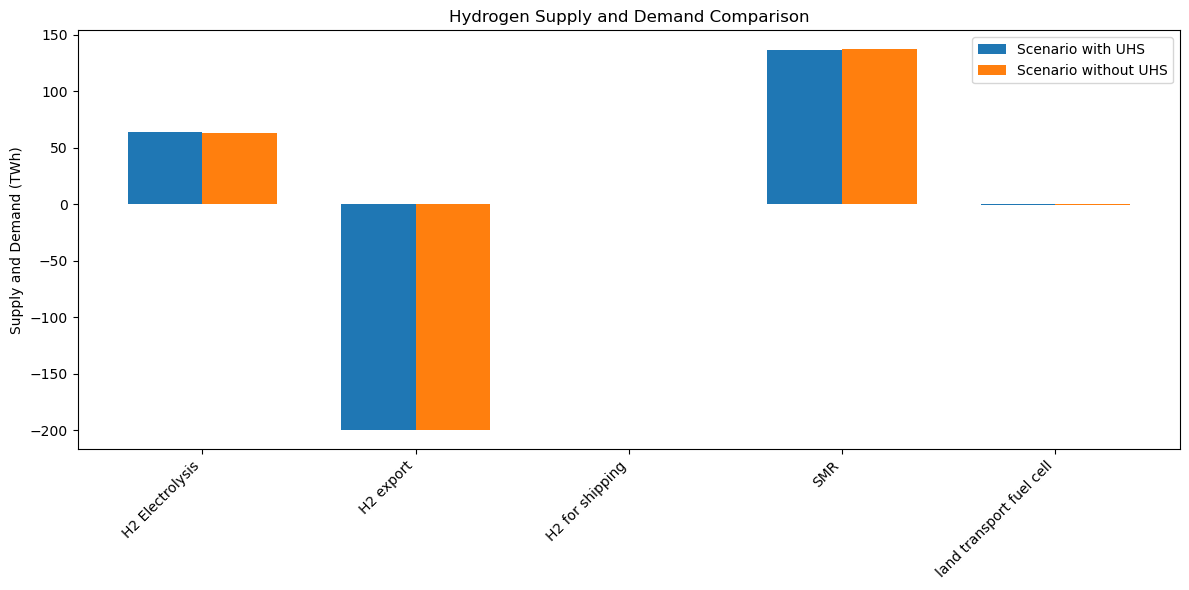

In [ ]:
threshold = 1e-1
# --- Extract hydrogen-related capacities ---#
# Extract hydrogen-related energy balances for UHS and woUHS
uhs_hydrogen_balance = uhs.statistics.energy_balance().loc[:, :, "H2"].groupby("carrier").sum().div(1e6)  # Convert to TWh
woUHS_hydrogen_balance = woUHS.statistics.energy_balance().loc[:, :, "H2"].groupby("carrier").sum().div(1e6)  # Convert to TWh
# Combine for consistent order
all_hydrogen_carriers = sorted(set(uhs_hydrogen_balance.index) | set(woUHS_hydrogen_balance.index))
uhs_hydrogen_balance = uhs_hydrogen_balance.reindex(all_hydrogen_carriers, fill_value=0)
woUHS_hydrogen_balance = woUHS_hydrogen_balance.reindex(all_hydrogen_carriers, fill_value=0)

# --- Filter: keep only carriers with actual (non-zero) energy flows in either scenario ---
combined_balance = uhs_hydrogen_balance.abs() + woUHS_hydrogen_balance.abs()

mask = combined_balance > threshold

uhs_hydrogen_balance = uhs_hydrogen_balance[mask]
woUHS_hydrogen_balance = woUHS_hydrogen_balance[mask]
all_hydrogen_carriers = uhs_hydrogen_balance.index.tolist()

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 6))

width = 0.35  # Width of the bars
x = np.arange(len(all_hydrogen_carriers))  # Carrier positions on x-axis

# Bars for UHS scenario
ax.bar(x - width/2, uhs_hydrogen_balance, width, color=SCENARIO_COLORS["UHS"], label="Scenario with UHS")

# Bars for woUHS scenario
ax.bar(x + width/2, woUHS_hydrogen_balance, width, color=SCENARIO_COLORS["woUHS"], label="Scenario without UHS")

# Axis labels and title
ax.set_xticks(x)
ax.set_xticklabels(all_hydrogen_carriers, rotation=45, ha="right")
ax.set_ylabel("Supply and Demand (TWh)")
ax.set_title("Hydrogen Supply and Demand Comparison")

# Legend
ax.legend()

plt.tight_layout()
plt.show()

##### Energy Balance

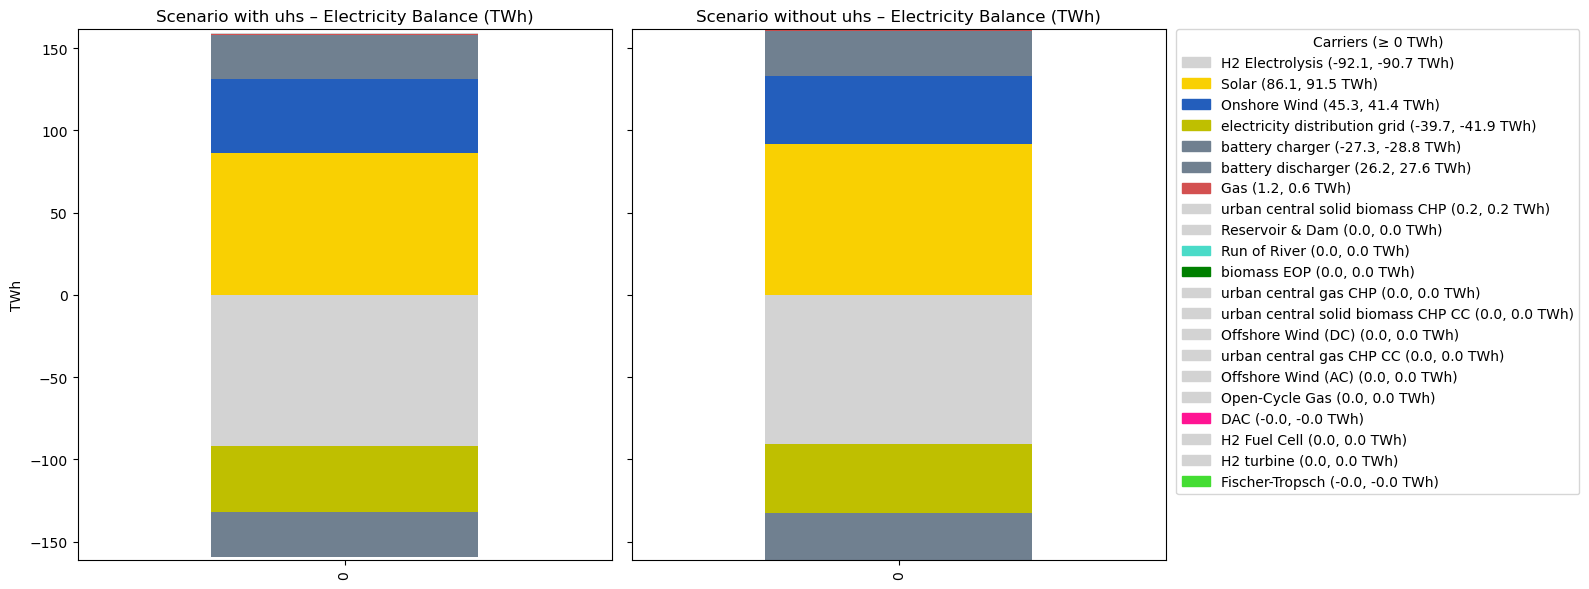

In [ ]:
# =========================
# User-adjustable threshold
# =========================
THRESHOLD_TWH = 0   # hide carriers with |value| < 0.1 TWh in BOTH scenarios
LEGEND_THRESHOLD_TWH = 0  # show only carriers >= 10 TWh in legend

def compute_energy_balance(n: pypsa.Network) -> pd.Series:
    rename_cols = {
        "-": "Load",
        "load": "load shedding",
    }

    # Aggregate energy balance by carrier and convert MWh -> TWh
    eb = (
        n.statistics.energy_balance()
        .loc[:, :, "Ac"]
        .groupby("carrier")
        .sum()
        .div(1e6)  # MWh -> TWh
        .rename(index=rename_cols)
    )

    # If result is a DataFrame (multiple columns), reduce to a single number per carrier
    if isinstance(eb, pd.DataFrame):
        eb = eb.sum(axis=1)

    return eb.fillna(0.0)


# --- Compute data (as Series) ---
s_uhs = compute_energy_balance(uhs)
s_woUHS = compute_energy_balance(woUHS)

# Harmonize index (carriers) between scenarios
all_carriers = sorted(set(s_uhs.index) | set(s_woUHS.index))
s_uhs = s_uhs.reindex(all_carriers, fill_value=0.0)
s_woUHS = s_woUHS.reindex(all_carriers, fill_value=0.0)

# --- Apply threshold: keep only carriers with meaningful flows in either scenario ---
mask = (s_uhs.abs() >= THRESHOLD_TWH) | (s_woUHS.abs() >= THRESHOLD_TWH)
s_uhs = s_uhs.loc[mask]
s_woUHS = s_woUHS.loc[mask]

# Sort carriers by combined absolute magnitude (more stable than raw sum if signs mix)
order = (s_uhs.abs() + s_woUHS.abs()).sort_values(ascending=False).index.tolist()
s_uhs = s_uhs.reindex(order)
s_woUHS = s_woUHS.reindex(order)

# Convert to 1-row DataFrames for your bar plotting style
df_uhs = s_uhs.to_frame().T
df_woUHS = s_woUHS.to_frame().T

# --- Assign colors ---
colors = [get_color(c) for c in order]

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

df_uhs.plot.bar(
    stacked=True,
    ax=axes[0],
    legend=False,
    title="Scenario with uhs – Electricity Balance (TWh)",
    color=colors
)
axes[0].set_xlabel("")
axes[0].set_ylabel("TWh")

df_woUHS.plot.bar(
    stacked=True,
    ax=axes[1],
    legend=False,
    title="Scenario without uhs – Electricity Balance (TWh)",
    color=colors
)
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# --- Manually build the legend (threshold-controlled) ---
labels, handles = [], []
for c, col in zip(order, colors):
    val_uhs = float(df_uhs.iloc[0][c])
    val_woUHS = float(df_woUHS.iloc[0][c])

    if (abs(val_uhs) >= LEGEND_THRESHOLD_TWH) or (abs(val_woUHS) >= LEGEND_THRESHOLD_TWH):
        labels.append(f"{c} ({val_uhs:.1f}, {val_woUHS:.1f} TWh)")
        handles.append(plt.Rectangle((0, 0), 1, 1, color=col))

axes[1].legend(
    handles,
    labels,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    title=f"Carriers (≥ {LEGEND_THRESHOLD_TWH} TWh)"
)

plt.tight_layout()
plt.show()


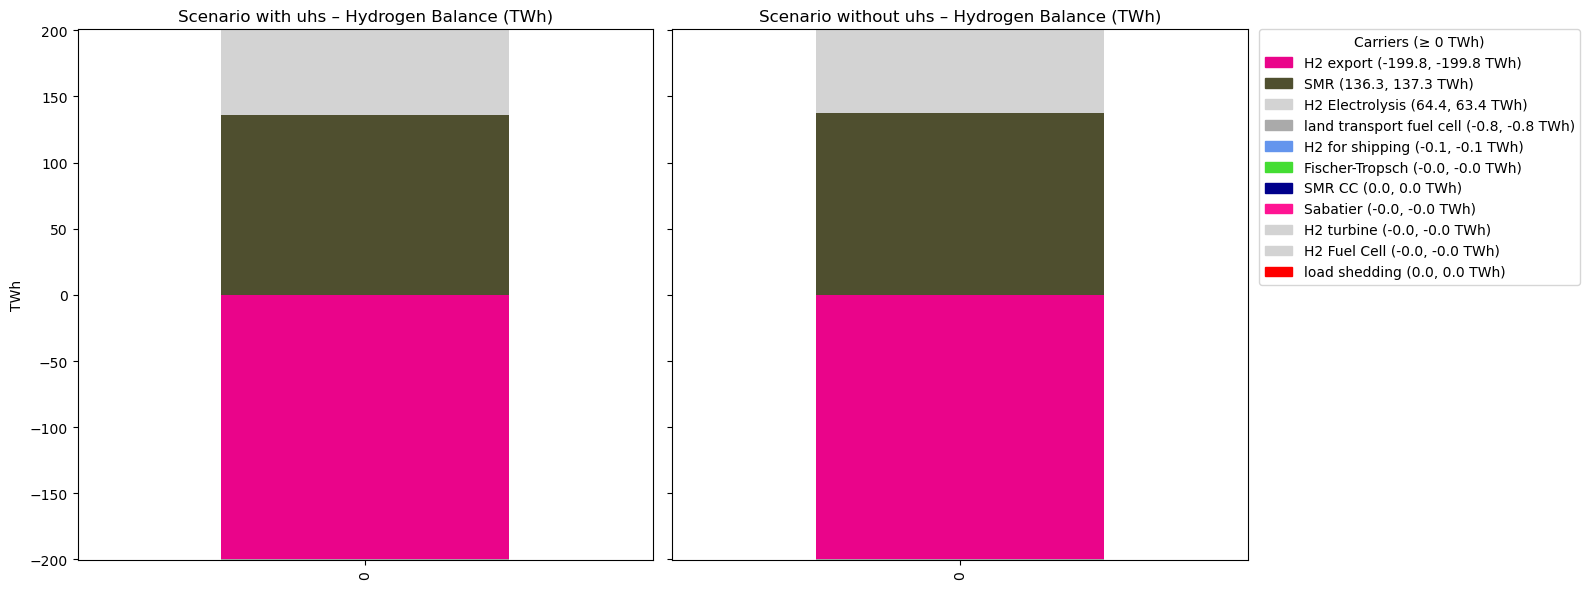

In [ ]:
# =========================
# User-adjustable threshold
# =========================
THRESHOLD_TWH = 0   # hide carriers with |value| < 0.1 TWh in BOTH scenarios
LEGEND_THRESHOLD_TWH = 0  # show only carriers >= 10 TWh in legend

def compute_energy_balance(n: pypsa.Network) -> pd.Series:
    rename_cols = {
        "-": "Load",
        "load": "load shedding",
    }

    # Aggregate energy balance by carrier and convert MWh -> TWh
    eb = (
        n.statistics.energy_balance()
        .loc[:, :, "H2"]
        .groupby("carrier")
        .sum()
        .div(1e6)  # MWh -> TWh
        .rename(index=rename_cols)
    )

    # If result is a DataFrame (multiple columns), reduce to a single number per carrier
    if isinstance(eb, pd.DataFrame):
        eb = eb.sum(axis=1)

    return eb.fillna(0.0)


# --- Compute data (as Series) ---
s_uhs = compute_energy_balance(uhs)
s_woUHS = compute_energy_balance(woUHS)

# Harmonize index (carriers) between scenarios
all_carriers = sorted(set(s_uhs.index) | set(s_woUHS.index))
s_uhs = s_uhs.reindex(all_carriers, fill_value=0.0)
s_woUHS = s_woUHS.reindex(all_carriers, fill_value=0.0)

# --- Apply threshold: keep only carriers with meaningful flows in either scenario ---
mask = (s_uhs.abs() >= THRESHOLD_TWH) | (s_woUHS.abs() >= THRESHOLD_TWH)
s_uhs = s_uhs.loc[mask]
s_woUHS = s_woUHS.loc[mask]

# Sort carriers by combined absolute magnitude (more stable than raw sum if signs mix)
order = (s_uhs.abs() + s_woUHS.abs()).sort_values(ascending=False).index.tolist()
s_uhs = s_uhs.reindex(order)
s_woUHS = s_woUHS.reindex(order)

# Convert to 1-row DataFrames for your bar plotting style
df_uhs = s_uhs.to_frame().T
df_woUHS = s_woUHS.to_frame().T

# --- Assign colors ---
colors = [get_color(c) for c in order]

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

df_uhs.plot.bar(
    stacked=True,
    ax=axes[0],
    legend=False,
    title="Scenario with uhs – Hydrogen Balance (TWh)",
    color=colors
)
axes[0].set_xlabel("")
axes[0].set_ylabel("TWh")

df_woUHS.plot.bar(
    stacked=True,
    ax=axes[1],
    legend=False,
    title="Scenario without uhs – Hydrogen Balance (TWh)",
    color=colors
)
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# --- Manually build the legend (threshold-controlled) ---
labels, handles = [], []
for c, col in zip(order, colors):
    val_uhs = float(df_uhs.iloc[0][c])
    val_woUHS = float(df_woUHS.iloc[0][c])

    if (abs(val_uhs) >= LEGEND_THRESHOLD_TWH) or (abs(val_woUHS) >= LEGEND_THRESHOLD_TWH):
        labels.append(f"{c} ({val_uhs:.1f}, {val_woUHS:.1f} TWh)")
        handles.append(plt.Rectangle((0, 0), 1, 1, color=col))

axes[1].legend(
    handles,
    labels,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    title=f"Carriers (≥ {LEGEND_THRESHOLD_TWH} TWh)"
)

plt.tight_layout()
plt.show()


##### Heating Supply Distribution

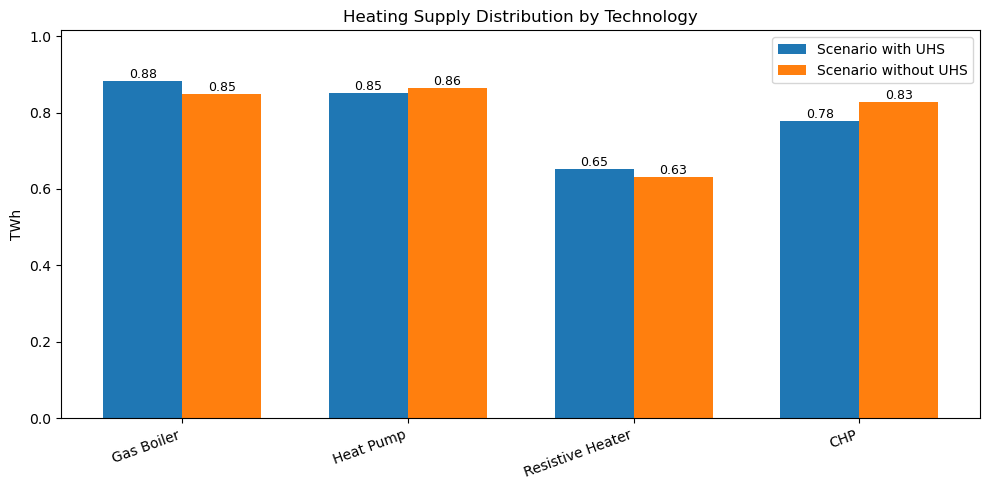

In [ ]:
logging.getLogger("pypsa.statistics").setLevel(logging.ERROR)
warnings.simplefilter(action='ignore', category=UserWarning)

# Adjustable settings
heating_map = {
    "Gas Boiler": ["gas boiler", "boiler"],
    "Heat Pump": ["heat pump"],
    "Resistive Heater": ["resistive heater", "resistive"],
    "CHP": ["chp"],
}

TO_TWH = True  # False -> MWh

def heating_distribution(n: pypsa.Network, tech_map=heating_map) -> pd.Series:
    s = (
        n.statistics.supply(comps=["Link"], aggregate_time="sum")
        .loc[lambda x: x.index.get_level_values("carrier")
             .str.contains("heat|boiler|pump|chp", case=False, na=False)]
    )

    carriers = pd.Index(s.index.get_level_values("carrier"))

    def sum_for_patterns(patterns) -> float:
        mask = np.zeros(len(carriers), dtype=bool)
        for p in patterns:
            mask |= np.asarray(carriers.str.contains(p, case=False, na=False))
        if not mask.any():
            return 0.0
        return float(s.loc[mask].sum(numeric_only=True).sum())

    data = {label: sum_for_patterns(patterns) for label, patterns in tech_map.items()}
    return pd.Series(data, index=list(tech_map.keys())).fillna(0.0)


# --- Compute totals ---
uhs_mwh = heating_distribution(uhs)
woUHS_mwh = heating_distribution(woUHS)

df = pd.DataFrame({
    "Scenario with UHS": uhs_mwh,
    "Scenario without UHS": woUHS_mwh
})

# Unit conversion
if TO_TWH:
    df = df / 1e6
    y_label = "TWh"
    value_fmt = "{:.2f}"
else:
    y_label = "MWh"
    value_fmt = "{:,.0f}"
# --- Plot: grouped bar chart ---
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(df.index))
width = 0.35

ax.bar(
    x - width / 2,
    df["Scenario with UHS"].values,
    width,
    label="Scenario with UHS",
    color=SCENARIO_COLORS["UHS"],
)

ax.bar(
    x + width / 2,
    df["Scenario without UHS"].values,
    width,
    label="Scenario without UHS",
    color=SCENARIO_COLORS["woUHS"],
)

ax.set_xticks(x)
ax.set_xticklabels(df.index, rotation=20, ha="right")
ax.set_ylabel(y_label)
ax.set_title("Heating Supply Distribution by Technology")
ax.legend()

# --- Y-axis alignment ---
ymax = max(df.values.max(), 1e-9)
ax.set_ylim(0, ymax * 1.15)

# --- Value labels ---
for i, tech in enumerate(df.index):
    v1 = df.loc[tech, "Scenario with UHS"]
    v2 = df.loc[tech, "Scenario without UHS"]

    ax.text(i - width / 2, v1, value_fmt.format(v1),
            ha="center", va="bottom", fontsize=9)
    ax.text(i + width / 2, v2, value_fmt.format(v2),
            ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

warnings.simplefilter(action='default', category=UserWarning)


#### Hydrogen prices

##### CAPEX

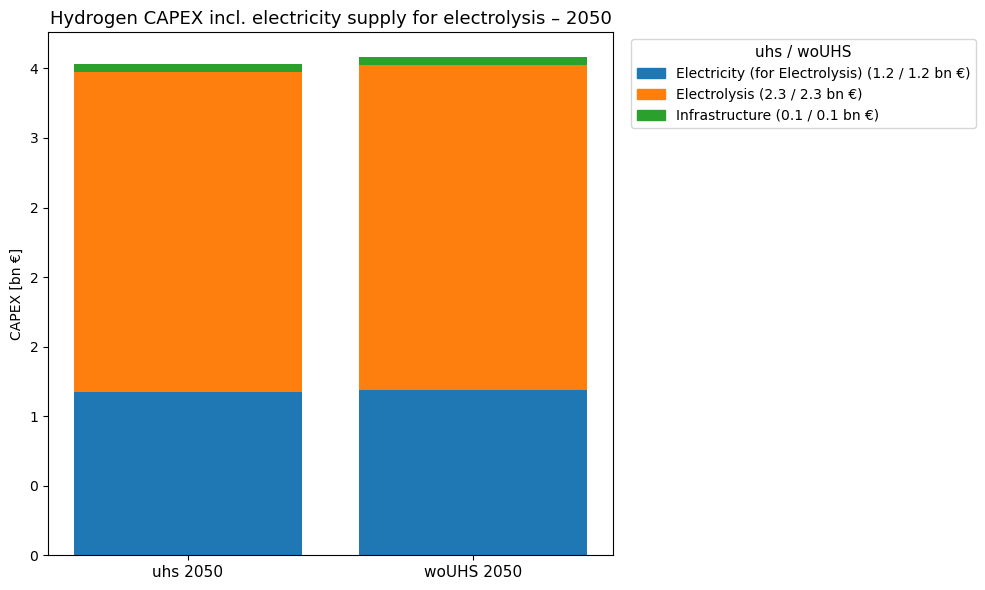

In [ ]:
def _snapshot_weights(net):
    if hasattr(net, "snapshot_weightings") and net.snapshot_weightings is not None:
        try:
            if "generators" in net.snapshot_weightings:
                return net.snapshot_weightings["generators"]
        except Exception:
            pass
    return pd.Series(1.0, index=net.snapshots)

def electricity_capex_for_electrolysis(net, electrolysis_carrier="H2 Electrolysis"):
    """
    Allocate generator CAPEX proportionally to the electricity actually used by electrolysis.
    Returns CAPEX [€] attributed to electrolysis electricity supply.
    """
    w = _snapshot_weights(net)

    # --- Electrolysis electricity consumption ---
    el = net.links[net.links.carrier == electrolysis_carrier]
    if el.empty:
        return 0.0

    p0 = net.links_t.p0[el.index]  # MW

    # Detect sign convention
    cons_pos = (p0.clip(lower=0).mul(w, axis=0)).sum().sum()
    cons_neg = ((-p0).clip(lower=0).mul(w, axis=0)).sum().sum()
    cons = p0.clip(lower=0) if cons_pos >= cons_neg else (-p0).clip(lower=0)

    # Total electricity consumed by electrolysis [MWh]
    E_el = (cons.mul(w, axis=0)).sum().sum()

    if E_el == 0:
        return 0.0

    # --- Generator production ---
    gens = net.generators.copy()
    p = net.generators_t.p[gens.index]  # MW
    E_gen = (p.mul(w, axis=0)).sum()    # MWh per generator

    total_E_gen = E_gen.sum()
    if total_E_gen == 0:
        return 0.0

    # --- Generator CAPEX ---
    p_nom = gens["p_nom_opt"] if "p_nom_opt" in gens.columns else gens["p_nom"]
    capex_gen = (p_nom * gens["capital_cost"]).fillna(0.0)

    # --- Allocate CAPEX by energy share ---
    share_el = E_el / total_E_gen
    capex_el_electricity = capex_gen.sum() * share_el

    return float(capex_el_electricity)

def hydrogen_capex_breakdown(net):
    """
    CAPEX [€] for hydrogen system, including ELECTRICITY CAPEX for electrolysis.
    """
    electrolysis = {"H2 Electrolysis"}

    h2_like = set(
        net.links.loc[
            net.links.carrier.astype(str).str.contains("H2", case=False, na=False),
            "carrier"
        ].unique()
    )
    infrastructure = h2_like - electrolysis

    def capex_links(carriers):
        links = net.links[net.links.carrier.isin(carriers)]
        if links.empty:
            return 0.0
        p_nom = links["p_nom_opt"] if "p_nom_opt" in links.columns else links["p_nom"]
        return float((p_nom * links["capital_cost"]).fillna(0.0).sum())

    return {
        "Electricity (for Electrolysis)": electricity_capex_for_electrolysis(net),
        "Electrolysis": capex_links(electrolysis),
        "Infrastructure": capex_links(infrastructure),
    }

# ============================
# Compute & plot
# ============================
capex_uhs = hydrogen_capex_breakdown(uhs)
capex_woUHS = hydrogen_capex_breakdown(woUHS)

cats = ["Electricity (for Electrolysis)", "Electrolysis", "Infrastructure"]
df = pd.DataFrame({
    "uhs 2050": pd.Series(capex_uhs).reindex(cats).fillna(0.0),
    "woUHS 2050": pd.Series(capex_woUHS).reindex(cats).fillna(0.0),
})

# ---------- helper for nicer units ----------
def billions(x, pos):
    return f"{x/1e10:.1f}"

# ---------- plot ----------
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(2)
bottom = np.zeros(2)

for cat in df.index:
    vals = df.loc[cat, ["uhs 2050", "woUHS 2050"]].values.astype(float)
    ax.bar(x, vals, bottom=bottom)
    bottom += vals

# ---------- axis formatting ----------
ax.set_xticks(x)
ax.set_xticklabels(["uhs 2050", "woUHS 2050"], fontsize=11)

ax.set_ylabel("CAPEX [bn €]")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x/1e9:.0f}"))
ax.tick_params(axis="y", labelsize=10)

ax.set_title("Hydrogen CAPEX incl. electricity supply for electrolysis – 2050", fontsize=13)

# ---------- clean legend ----------
legend_labels = []
for cat in df.index:
    d = df.loc[cat, "uhs 2050"] / 1e9
    w = df.loc[cat, "woUHS 2050"] / 1e9
    legend_labels.append(f"{cat} ({d:.1f} / {w:.1f} bn €)")

handles = [
    plt.Rectangle((0, 0), 1, 1, color=plt.cm.tab10(i))
    for i in range(len(df.index))
]

ax.legend(
    handles,
    legend_labels,
    title="uhs / woUHS",
    fontsize=10,
    title_fontsize=11,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=True,
)

plt.tight_layout()
plt.show()

##### OPEX

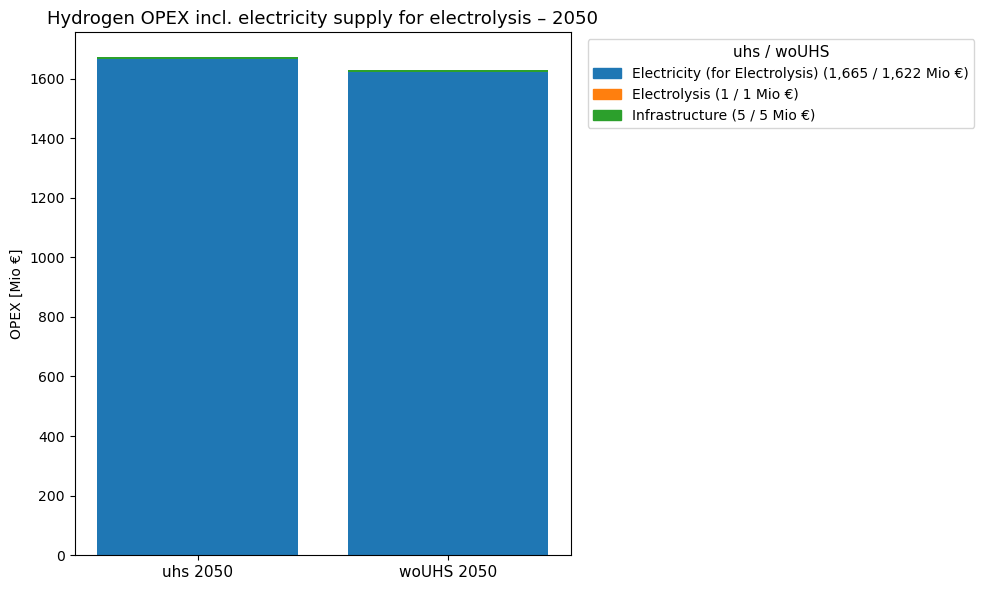

In [ ]:
def _snapshot_weights(net):
    if hasattr(net, "snapshot_weightings") and net.snapshot_weightings is not None:
        try:
            if "generators" in net.snapshot_weightings:
                return net.snapshot_weightings["generators"]
        except Exception:
            pass
    return pd.Series(1.0, index=net.snapshots)

def electricity_opex_for_electrolysis(net, electrolysis_carrier="H2 Electrolysis"):
    """
    Allocate generator OPEX (dispatch-based marginal costs) proportionally to electricity used by electrolysis.
    Returns OPEX [€] attributed to electrolysis electricity supply.

    Note: This attributes VARIABLE generation costs (marginal_cost) to electrolysis.
    It does NOT include generator fixed O&M unless you model it via capital_cost or separate components.
    """
    w = _snapshot_weights(net)

    # --- Electrolysis electricity consumption ---
    el = net.links[net.links.carrier == electrolysis_carrier]
    if el.empty:
        return 0.0

    p0_el = net.links_t.p0[el.index]  # MW
    cons_pos = (p0_el.clip(lower=0).mul(w, axis=0)).sum().sum()
    cons_neg = ((-p0_el).clip(lower=0).mul(w, axis=0)).sum().sum()
    cons_el = p0_el.clip(lower=0) if cons_pos >= cons_neg else (-p0_el).clip(lower=0)

    E_el = (cons_el.mul(w, axis=0)).sum().sum()  # MWh
    if E_el == 0:
        return 0.0

    # --- Generator dispatch energy & variable cost ---
    gens = net.generators.copy()
    if gens.empty:
        return 0.0

    p = net.generators_t.p[gens.index]  # MW
    E_gen = (p.mul(w, axis=0)).sum()    # MWh per generator
    total_E_gen = E_gen.sum()
    if total_E_gen == 0:
        return 0.0

    mc = gens["marginal_cost"].fillna(0.0)  # €/MWh
    gen_opex = float((E_gen * mc).sum())    # €/a (variable part)

    # --- Allocate by energy share (same logic as CAPEX allocation) ---
    share_el = E_el / total_E_gen
    return gen_opex * float(share_el)

def hydrogen_opex_breakdown(net):
    """
    OPEX [€] for hydrogen system (variable OPEX from marginal_cost), including:
      - Electricity (for Electrolysis): allocated generator variable cost share
      - Electrolysis: link marginal_cost * |p0| throughput (MWh)
      - Infrastructure: link marginal_cost * |p0| throughput (MWh)
    """
    w = _snapshot_weights(net)

    electrolysis = {"H2 Electrolysis"}

    h2_like = set(
        net.links.loc[
            net.links.carrier.astype(str).str.contains("H2", case=False, na=False),
            "carrier"
        ].unique()
    )
    infrastructure = h2_like - electrolysis

    def link_opex(carriers):
        links = net.links[net.links.carrier.isin(carriers)].copy()
        if links.empty:
            return 0.0
        mc = links["marginal_cost"].fillna(0.0)  # €/MWh
        p0 = net.links_t.p0[links.index]          # MW
        E = (p0.abs().mul(w, axis=0)).sum()       # MWh per link
        return float((E * mc).sum())

    return {
        "Electricity (for Electrolysis)": electricity_opex_for_electrolysis(net, electrolysis_carrier="H2 Electrolysis"),
        "Electrolysis": link_opex(electrolysis),
        "Infrastructure": link_opex(infrastructure),
    }

# ============================
# Compute & plot
# ============================
opex_uhs = hydrogen_opex_breakdown(uhs)
opex_woUHS = hydrogen_opex_breakdown(woUHS)

cats = ["Electricity (for Electrolysis)", "Electrolysis", "Infrastructure"]
df = pd.DataFrame({
    "uhs 2050": pd.Series(opex_uhs).reindex(cats).fillna(0.0),
    "woUHS 2050": pd.Series(opex_woUHS).reindex(cats).fillna(0.0),
})

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(2)
bottom = np.zeros(2)

for cat in df.index:
    vals = df.loc[cat, ["uhs 2050", "woUHS 2050"]].values.astype(float)
    ax.bar(x, vals, bottom=bottom)
    bottom += vals

ax.set_xticks(x)
ax.set_xticklabels(["uhs 2050", "woUHS 2050"], fontsize=11)

ax.set_ylabel("OPEX [Mio €]")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x/1e6:.0f}"))
ax.tick_params(axis="y", labelsize=10)

ax.set_title("Hydrogen OPEX incl. electricity supply for electrolysis – 2050", fontsize=13)

legend_labels = []
for cat in df.index:
    d_mio = df.loc[cat, "uhs 2050"] / 1e6
    w_mio = df.loc[cat, "woUHS 2050"] / 1e6
    legend_labels.append(f"{cat} ({d_mio:,.0f} / {w_mio:,.0f} Mio €)")

handles = [
    plt.Rectangle((0, 0), 1, 1, color=plt.cm.tab10(i))
    for i in range(len(df.index))
]

ax.legend(
    handles,
    legend_labels,
    title="uhs / woUHS",
    fontsize=10,
    title_fontsize=11,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=True,
)

plt.tight_layout()
plt.show()

##### LCOH

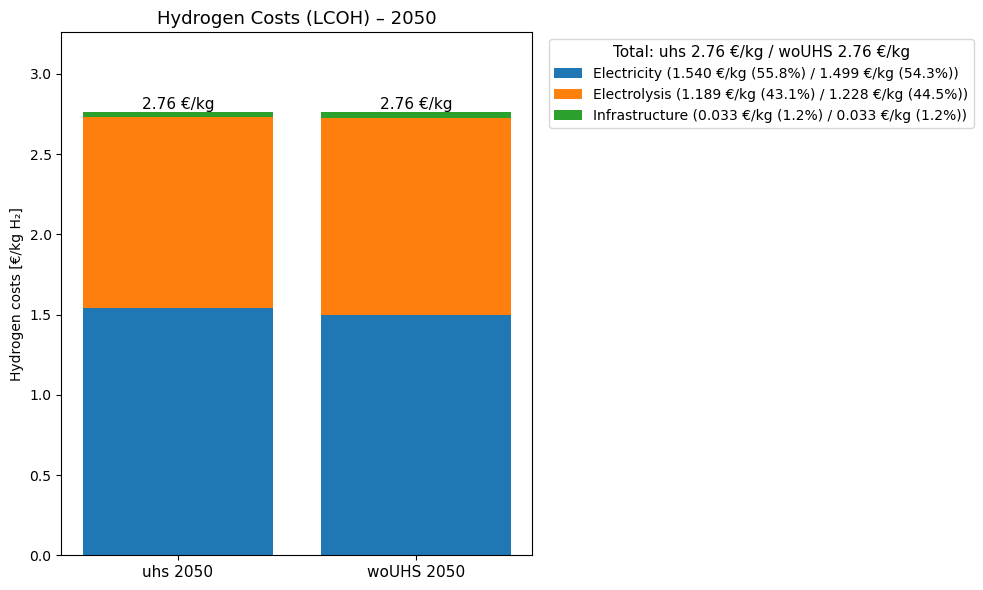

In [ ]:
def _snapshot_weights(net):
    if hasattr(net, "snapshot_weightings") and net.snapshot_weightings is not None:
        try:
            if "generators" in net.snapshot_weightings:
                return net.snapshot_weightings["generators"]
        except Exception:
            pass
    return pd.Series(1.0, index=net.snapshots)

def _annual_h2_output_kg_from_electrolysis(net, electrolysis_carrier="H2 Electrolysis", h2_lhv_kwh_per_kg=33.33):
    w = _snapshot_weights(net)
    el = net.links[net.links.carrier == electrolysis_carrier]
    if el.empty:
        raise ValueError(f"No links with carrier '{electrolysis_carrier}' found.")
    p1 = net.links_t.p1[el.index]  # MW (sign may vary)
    e_mwh = (p1.abs().mul(w, axis=0)).sum().sum()
    e_kwh = float(e_mwh) * 1_000.0
    return e_kwh / h2_lhv_kwh_per_kg

def _capex_links(net, carriers):
    links = net.links[net.links.carrier.isin(carriers)].copy()
    if links.empty:
        return 0.0
    p_nom = links["p_nom_opt"] if "p_nom_opt" in links.columns else links["p_nom"]
    return float((p_nom * links["capital_cost"]).fillna(0.0).sum())

def _vopex_links(net, carriers):
    links = net.links[net.links.carrier.isin(carriers)].copy()
    if links.empty:
        return 0.0
    w = _snapshot_weights(net)
    mc = links["marginal_cost"].fillna(0.0)
    p0 = net.links_t.p0[links.index]
    e_mwh = (p0.abs().mul(w, axis=0)).sum()  # MWh per link-year
    return float((e_mwh * mc).sum())

def _electricity_cost_for_electrolysis(net, electrolysis_carrier="H2 Electrolysis"):
    """
    Annual electricity cost [€] for electrolysis using nodal marginal prices at bus0.
    Robust to sign convention on p0.
    """
    if not hasattr(net, "buses_t") or not hasattr(net.buses_t, "marginal_price"):
        raise ValueError("net.buses_t.marginal_price not found (no dual prices stored).")

    el = net.links[net.links.carrier == electrolysis_carrier].copy()
    if el.empty:
        return 0.0

    w = _snapshot_weights(net)
    p0 = net.links_t.p0[el.index]  # MW

    cons_pos = (p0.clip(lower=0).mul(w, axis=0)).sum().sum()
    cons_neg = ((-p0).clip(lower=0).mul(w, axis=0)).sum().sum()
    cons = p0.clip(lower=0) if cons_pos >= cons_neg else (-p0).clip(lower=0)

    price_mat = pd.DataFrame({link: net.buses_t.marginal_price[bus] for link, bus in el["bus0"].items()})
    return float(((cons.mul(w, axis=0)) * price_mat).sum().sum())

def hydrogen_costs_breakdown(net, include_all_h2_infrastructure=True):
    """
    Returns cost contributions in €/kg H2 (Paper-style) for:
      - Electricity (for electrolysis, via marginal prices)
      - Electrolysis (links CAPEX + links variable OPEX)
      - Water (uhs + H2O infra links CAPEX + variable OPEX)
      - Infrastructure (H2-related links excl electrolysis & water, CAPEX + variable OPEX)
    """
    h2_kg = _annual_h2_output_kg_from_electrolysis(net, electrolysis_carrier="H2 Electrolysis")

    # Carrier sets
    electrolysis = {"H2 Electrolysis"}
    pipelines = {"H2 pipeline"}

    # Infrastructure carriers: all H2-related links excluding electrolysis and water (and optionally excluding conversion tech)
    if include_all_h2_infrastructure:
        h2_like = set(net.links.loc[net.links.carrier.astype(str).str.contains("H2", case=False, na=False), "carrier"].unique())
        infra = (h2_like - electrolysis) | pipelines
    else:
        infra = set(pipelines)

    # Annual costs [€]
    elec_cost = _electricity_cost_for_electrolysis(net, electrolysis_carrier="H2 Electrolysis")

    el_cost = _capex_links(net, electrolysis) + _vopex_links(net, electrolysis)
    i_cost  = _capex_links(net, infra)       + _vopex_links(net, infra)

    # Convert to €/kg
    return {
        "Electricity": elec_cost / h2_kg,
        "Electrolysis": el_cost / h2_kg,
        "Infrastructure": i_cost / h2_kg,
    }

# ============================
# Compute & plot costs (€/kg H2) for both scenarios
# ============================
cost_uhs = hydrogen_costs_breakdown(uhs, include_all_h2_infrastructure=True)
cost_woUHS = hydrogen_costs_breakdown(woUHS, include_all_h2_infrastructure=True)

cats = ["Electricity", "Electrolysis", "Infrastructure"]
df = pd.DataFrame({
    "uhs 2050": pd.Series(cost_uhs).reindex(cats).fillna(0.0),
    "woUHS 2050": pd.Series(cost_woUHS).reindex(cats).fillna(0.0),
})

# Plot stacked costs with values on legend title
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(2)
bottom = np.zeros(2)

handles = []
legend_labels = []

total_d = df["uhs 2050"].sum()
total_w = df["woUHS 2050"].sum()

colors = plt.cm.tab10.colors

for i, cat in enumerate(df.index):
    vals = df.loc[cat, ["uhs 2050", "woUHS 2050"]].values.astype(float)
    bars = ax.bar(x, vals, bottom=bottom, color=colors[i % len(colors)])
    bottom += vals

    d = df.loc[cat, "uhs 2050"]
    wv = df.loc[cat, "woUHS 2050"]
    d_pct = 100 * d / total_d if total_d > 0 else 0.0
    w_pct = 100 * wv / total_w if total_w > 0 else 0.0

    legend_labels.append(f"{cat} ({d:.3f} €/kg ({d_pct:.1f}%) / {wv:.3f} €/kg ({w_pct:.1f}%))")
    handles.append(bars[0])

# Label totals on bars
for xi, total in zip(x, [total_d, total_w]):
    ax.text(xi, total, f"{total:.2f} €/kg", ha="center", va="bottom", fontsize=11)

# Headroom
ax.set_ylim(0, max(total_d, total_w) * 1.18)

ax.set_xticks(x)
ax.set_xticklabels(["uhs 2050", "woUHS 2050"], fontsize=11)
ax.set_ylabel("Hydrogen costs [€/kg H₂]")
ax.set_title("Hydrogen Costs (LCOH) – 2050", fontsize=13)

ax.legend(
    handles,
    legend_labels,
    title=f"Total: uhs {total_d:.2f} €/kg / woUHS {total_w:.2f} €/kg",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    fontsize=10,
    title_fontsize=11,
    frameon=True
)

plt.tight_layout()
plt.show()

##### Supply

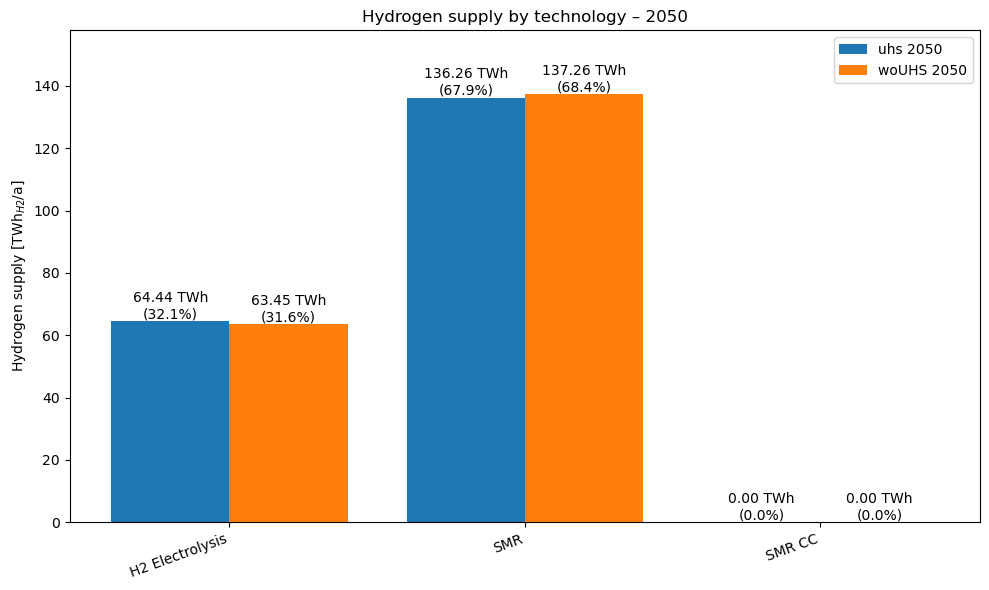

In [ ]:
def hydrogen_supply_by_tech(net, h2_lhv_kwh_per_kg=33.33):
    """
    H2 supply by technology (carrier) from NON-H2 -> H2 links.
    Robust to PyPSA link sign conventions.
    """
    w = _snapshot_weights(net)

    # Identify H2 buses
    h2_buses = net.buses.index[net.buses.carrier == "H2"]
    if len(h2_buses) == 0:
        raise ValueError("No H2 buses found (carrier == 'H2').")

    # Links feeding into H2
    cand = net.links[net.links.bus1.isin(h2_buses)].copy()

    # Exclude H2->H2 transport (pipelines)
    supply_links = cand[~cand.bus0.isin(h2_buses)].copy()
    if supply_links.empty:
        raise ValueError("No NON-H2 -> H2 supply links found.")

    # Annual H2 energy into H2 bus (ABS handles sign conventions)
    p1 = net.links_t.p1[supply_links.index]     # MW
    e_mwh = (p1.abs().mul(w, axis=0)).sum()     # MWh/a per link

    # Aggregate by technology
    e_mwh_by_carrier = e_mwh.groupby(supply_links["carrier"]).sum()

    # Convert units
    e_twh = e_mwh_by_carrier / 1e6
    e_kwh = e_mwh_by_carrier * 1_000.0
    mt_h2 = (e_kwh / h2_lhv_kwh_per_kg) / 1e9

    return pd.DataFrame({
        "Supply [TWh_H2]": e_twh,
        "Supply [Mt_H2]": mt_h2,
    }).sort_values("Supply [TWh_H2]", ascending=False)


supply_uhs = hydrogen_supply_by_tech(uhs)
supply_woUHS = hydrogen_supply_by_tech(woUHS)

techs = sorted(set(supply_uhs.index) | set(supply_woUHS.index))

plot_df = pd.DataFrame({
    "uhs 2050 [TWh_H2]": supply_uhs.reindex(techs)["Supply [TWh_H2]"].fillna(0.0),
    "woUHS 2050 [TWh_H2]": supply_woUHS.reindex(techs)["Supply [TWh_H2]"].fillna(0.0),
})

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(plot_df.index))
width = 0.4

vals_uhs = plot_df["uhs 2050 [TWh_H2]"].values
vals_woUHS = plot_df["woUHS 2050 [TWh_H2]"].values

bars_d = ax.bar(x - width/2, vals_uhs, width=width, label="uhs 2050")
bars_w = ax.bar(x + width/2, vals_woUHS, width=width, label="woUHS 2050")

# Axis formatting
ax.set_xticks(x)
ax.set_xticklabels(plot_df.index, rotation=20, ha="right")
ax.set_ylabel("Hydrogen supply [TWh$_{H2}$/a]")
ax.set_title("Hydrogen supply by technology – 2050")
ymax = max(vals_uhs.max(), vals_woUHS.max())
ax.set_ylim(0, ymax * 1.15)
ax.legend()

# Totals for percentages
total_d = vals_uhs.sum()
total_w = vals_woUHS.sum()

# ---------- annotate bars ----------
def annotate_bars(bars, total):
    for b in bars:
        height = b.get_height()
        if height <= 0:
            continue
        pct = 100 * height / total if total > 0 else 0.0
        ax.text(
            b.get_x() + b.get_width() / 2,
            height,
            f"{height:.2f} TWh\n({pct:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=10,
        )

annotate_bars(bars_d, total_d)
annotate_bars(bars_w, total_w)

plt.tight_layout()
plt.show()

##### Revenue

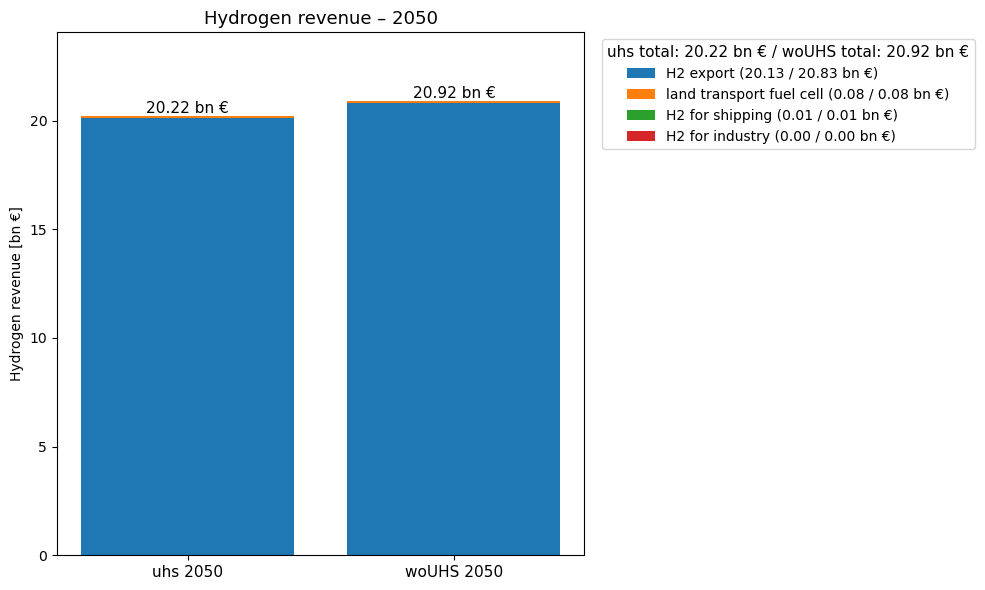

In [ ]:
def _snapshot_weights(net):
    if hasattr(net, "snapshot_weightings") and net.snapshot_weightings is not None:
        try:
            if "generators" in net.snapshot_weightings:
                return net.snapshot_weightings["generators"]
        except Exception:
            pass
    return pd.Series(1.0, index=net.snapshots)

def hydrogen_revenue(net, h2_bus_carrier="H2"):
    """
    Hydrogen revenue [€] computed as:
      Revenue = sum_t sum_{H2 loads} (H2_price_at_bus[t] * H2_load_power[t] * weight[t])

    Assumptions:
      - H2 price is net.buses_t.marginal_price at H2 buses [€/MWh_H2]
      - H2 demand is net.loads_t.p at loads connected to H2 buses [MW_H2]
      - Snapshot weights are hours, so MW * h = MWh

    Returns:
      total_revenue_eur, revenue_by_loadcarrier_eur (Series)
    """
    if not hasattr(net, "buses_t") or not hasattr(net.buses_t, "marginal_price"):
        raise ValueError("net.buses_t.marginal_price not found (no dual prices stored).")

    w = _snapshot_weights(net)

    # --- identify H2 buses ---
    h2_buses = net.buses.index[net.buses.carrier == h2_bus_carrier]
    if len(h2_buses) == 0:
        raise ValueError(f"No buses with carrier == '{h2_bus_carrier}' found.")

    # --- identify loads on H2 buses ---
    loads = net.loads.copy()
    h2_loads = loads[loads.bus.isin(h2_buses)].copy()
    if h2_loads.empty:
        # Nothing to sell H2 to -> revenue 0
        return 0.0, pd.Series(dtype=float)

    # Load time series [MW_H2]
    p_load = net.loads_t.p[h2_loads.index]

    # Bus prices [€/MWh_H2] for each load's bus, expanded to load columns
    price_mat = pd.DataFrame({ld: net.buses_t.marginal_price[bus] for ld, bus in h2_loads["bus"].items()})

    # Revenue per load [€]
    rev_per_load = ((p_load.mul(w, axis=0)) * price_mat).sum(axis=0)  # MWh * €/MWh

    # Group revenue by load carrier (or by load name if carrier missing)
    if "carrier" in h2_loads.columns:
        grp = h2_loads["carrier"].fillna("H2 load")
    else:
        grp = pd.Series("H2 load", index=h2_loads.index)

    rev_by_carrier = rev_per_load.groupby(grp).sum().sort_values(ascending=False)
    total_rev = float(rev_by_carrier.sum())

    return total_rev, rev_by_carrier

# ============================
# Compute revenues for both scenarios
# ============================
rev_uhs_total, rev_uhs_by = hydrogen_revenue(uhs, h2_bus_carrier="H2")
rev_woUHS_total, rev_woUHS_by = hydrogen_revenue(woUHS, h2_bus_carrier="H2")

# Align revenue categories (if you have multiple H2 demand types)
cats = sorted(set(rev_uhs_by.index) | set(rev_woUHS_by.index))
rev_df = pd.DataFrame({
    "uhs 2050": rev_uhs_by.reindex(cats).fillna(0.0),
    "woUHS 2050": rev_woUHS_by.reindex(cats).fillna(0.0),
})

# If there is only one category, it still plots cleanly.
# Sort by mean revenue so the largest categories are first
if len(cats) > 1:
    rev_df = rev_df.loc[rev_df.mean(axis=1).sort_values(ascending=False).index]

# ============================
# Plot: stacked revenues (bn €) with values on bars
# ============================
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(2)
bottom = np.zeros(2)

colors = plt.cm.tab10.colors
handles = []
legend_labels = []

for i, cat in enumerate(rev_df.index):
    vals = rev_df.loc[cat, ["uhs 2050", "woUHS 2050"]].values.astype(float)
    bars = ax.bar(x, vals, bottom=bottom, color=colors[i % len(colors)])
    bottom += vals

    # Legend: absolute revenues per category for both scenarios (bn €)
    d_bn = rev_df.loc[cat, "uhs 2050"] / 1e9
    w_bn = rev_df.loc[cat, "woUHS 2050"] / 1e9
    legend_labels.append(f"{cat} ({d_bn:.2f} / {w_bn:.2f} bn €)")
    handles.append(bars[0])

# Bar annotations: totals on top
totals = np.array([rev_uhs_total, rev_woUHS_total], dtype=float)
for xi, total in zip(x, totals):
    ax.text(xi, total, f"{total/1e9:.2f} bn €", ha="center", va="bottom", fontsize=11)

# Add headroom so text isn't clipped
ymax = max(totals.max(), 1.0)
ax.set_ylim(0, ymax * 1.15)

ax.set_xticks(x)
ax.set_xticklabels(["uhs 2050", "woUHS 2050"], fontsize=11)
ax.set_ylabel("Hydrogen revenue [bn €]")
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v/1e9:.0f}"))
ax.set_title("Hydrogen revenue – 2050", fontsize=13)

legend_title = f"uhs total: {rev_uhs_total/1e9:.2f} bn € / woUHS total: {rev_woUHS_total/1e9:.2f} bn €"
ax.legend(handles, legend_labels, title=legend_title,
          bbox_to_anchor=(1.02, 1), loc="upper left",
          fontsize=10, title_fontsize=11, frameon=True)

plt.tight_layout()
plt.show()

##### Hydrogen Market

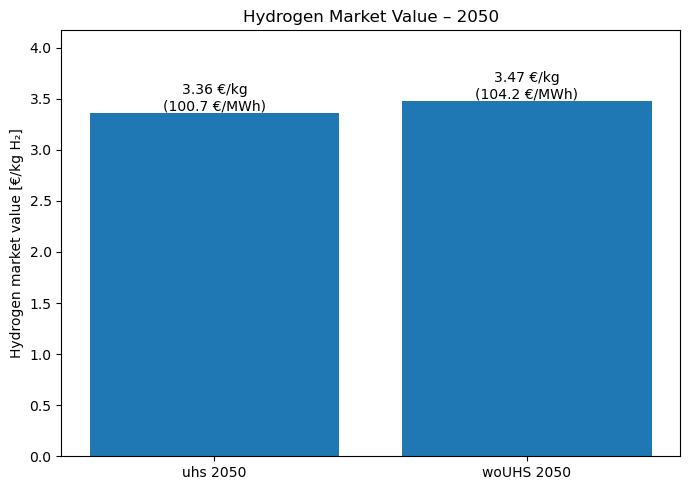

In [ ]:
def _snapshot_weights(net):
    if hasattr(net, "snapshot_weightings") and net.snapshot_weightings is not None:
        try:
            if "generators" in net.snapshot_weightings:
                return net.snapshot_weightings["generators"]
        except Exception:
            pass
    return pd.Series(1.0, index=net.snapshots)

def hydrogen_market_value(net, h2_bus_carrier="H2", h2_lhv_kwh_per_kg=33.33):
    """
    Hydrogen Market Value = revenue / quantity, computed primarily from H2 loads:
      MV [€/MWh_H2] = sum_t (p_load * w * price_bus) / sum_t (p_load * w)

    where price_bus is net.buses_t.marginal_price at the H2 bus (€/MWh_H2)
    and p_load is net.loads_t.p of loads connected to H2 buses (MW_H2).

    Returns:
      mv_eur_per_mwh, mv_eur_per_kg, total_revenue_eur, total_quantity_mwh
    """
    if not hasattr(net, "buses_t") or not hasattr(net.buses_t, "marginal_price"):
        raise ValueError("net.buses_t.marginal_price not found (no dual prices stored).")

    w = _snapshot_weights(net)

    # Identify H2 buses
    h2_buses = net.buses.index[net.buses.carrier == h2_bus_carrier]
    if len(h2_buses) == 0:
        raise ValueError(f"No buses with carrier == '{h2_bus_carrier}' found.")

    # H2 loads (buyers)
    h2_loads = net.loads[net.loads.bus.isin(h2_buses)].copy()
    if h2_loads.empty:
        raise ValueError("No H2 loads found on H2 buses (cannot compute market value from demand).")

    p_load = net.loads_t.p[h2_loads.index]  # MW_H2

    # Quantity [MWh_H2]
    q_mwh = float((p_load.mul(w, axis=0)).sum().sum())
    if q_mwh == 0:
        raise ValueError("Total H2 load energy is zero (cannot compute market value).")

    # Per-load price time series at the corresponding H2 bus
    price_mat = pd.DataFrame({ld: net.buses_t.marginal_price[bus] for ld, bus in h2_loads["bus"].items()})

    # Revenue [€]
    revenue_eur = float(((p_load.mul(w, axis=0)) * price_mat).sum().sum())

    mv_eur_per_mwh = revenue_eur / q_mwh

    # Convert €/MWh -> €/kg via LHV:
    # 1 MWh = 1000 kWh, kg = kWh / (kWh/kg) => kg per MWh = 1000 / LHV
    kg_per_mwh = 1000.0 / h2_lhv_kwh_per_kg
    mv_eur_per_kg = mv_eur_per_mwh / kg_per_mwh

    return mv_eur_per_mwh, mv_eur_per_kg, revenue_eur, q_mwh

# ============================
# Compute for both scenarios
# ============================
mv_d_mwh, mv_d_kg, rev_d, q_d = hydrogen_market_value(uhs, h2_bus_carrier="H2")
mv_w_mwh, mv_w_kg, rev_w, q_w = hydrogen_market_value(woUHS, h2_bus_carrier="H2")

# ============================
# Plot (€/kg H2) with values on bars
# ============================
fig, ax = plt.subplots(figsize=(7, 5))

labels = ["uhs 2050", "woUHS 2050"]
vals_kg = [mv_d_kg, mv_w_kg]

bars = ax.bar(labels, vals_kg)

ax.set_ylabel("Hydrogen market value [€/kg H₂]")
ax.set_title("Hydrogen Market Value – 2050")

# annotate bars (also show €/MWh_H2 in the label)
vals_mwh = [mv_d_mwh, mv_w_mwh]
for b, vkg, vmwh in zip(bars, vals_kg, vals_mwh):
    ax.text(
        b.get_x() + b.get_width() / 2,
        b.get_height(),
        f"{vkg:.2f} €/kg\n({vmwh:.1f} €/MWh)",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# add headroom to avoid clipping
ymax = max(vals_kg) if max(vals_kg) > 0 else 1.0
ax.set_ylim(0, ymax * 1.20)

plt.tight_layout()
plt.show()

##### Capacity

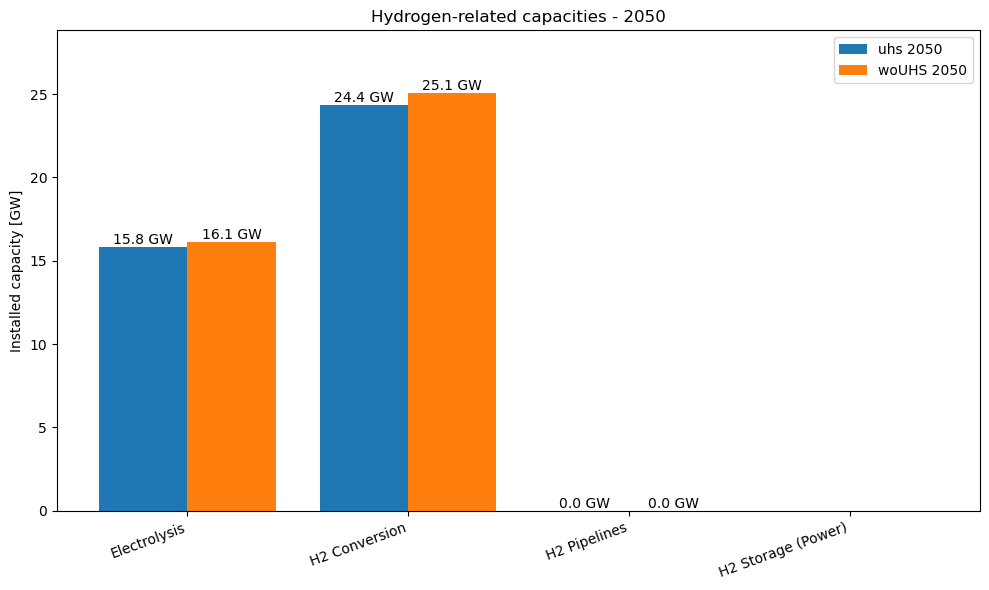

In [348]:
def hydrogen_capacities_breakdown(net):
    """
    Installed hydrogen-related capacities (using p_nom_opt if available) split into:
      - Electrolysis (H2 Electrolysis links)  [MW_el or MW_link]
      - H2 Pipelines (H2 pipeline links)      [MW_link]
      - H2 Storage (stores + storage_units with carrier containing 'H2') [MWh for Stores, MW for StorageUnits]
      - H2 Conversion (other links with carrier containing 'H2', excluding Electrolysis & pipelines) [MW_link]

    Returns:
      cap_MW: Series of MW-type capacities (Links + StorageUnits)
      cap_MWh: Series of MWh-type capacities (Stores)
    """
    # --- Links ---
    links = net.links.copy()
    pnom_col = "p_nom_opt" if "p_nom_opt" in links.columns else "p_nom"

    h2_buses = net.buses.index[net.buses.carrier == "H2"]

    # --- Electrolysis: electricity -> H2 ---
    electrolysis = links[links.carrier == "H2 Electrolysis"]

    # --- H2 pipelines: H2 -> H2 ---
    pipelines = links[
        (links.carrier == "H2 pipeline") &
        (links.bus0.isin(h2_buses)) &
        (links.bus1.isin(h2_buses))
    ]

    # --- H2 conversion: H2 <-> non-H2 (excluding electrolysis & pipelines) ---
    conversion = links[
        (
            links.bus0.isin(h2_buses) ^ links.bus1.isin(h2_buses)
        ) &
        (~links.index.isin(electrolysis.index)) &
        (~links.index.isin(pipelines.index))
    ]

    def sum_cap(df):
        if df.empty:
            return 0.0
        return float(df[pnom_col].fillna(0.0).sum())

    cap_MW = pd.Series({
        "Electrolysis": sum_cap(electrolysis),
        "H2 Pipelines": sum_cap(pipelines),
        "H2 Conversion": sum_cap(conversion),
    })

    # --- H2 storage (power & energy) ---
    cap_MW["H2 Storage (Power)"] = 0.0
    cap_MWh = pd.Series(dtype=float)

    if hasattr(net, "storage_units") and not net.storage_units.empty:
        su = net.storage_units
        su_pnom = "p_nom_opt" if "p_nom_opt" in su.columns else "p_nom"
        h2_su = su[su.bus.isin(h2_buses)]
        cap_MW["H2 Storage (Power)"] = float(h2_su[su_pnom].fillna(0.0).sum())

    if hasattr(net, "stores") and not net.stores.empty:
        st = net.stores
        st_enom = "e_nom_opt" if "e_nom_opt" in st.columns else "e_nom"
        h2_st = st[st.bus.isin(h2_buses)]
        cap_MWh["H2 Storage (Energy)"] = float(h2_st[st_enom].fillna(0.0).sum())

    return cap_MW, cap_MWh


# ============================
# Compute capacities for both scenarios
# ============================
cap_MW_uhs, cap_MWh_uhs = hydrogen_capacities_breakdown(uhs)
cap_MW_woUHS, cap_MWh_woUHS = hydrogen_capacities_breakdown(woUHS)

# Align indices
mw_cats = sorted(set(cap_MW_uhs.index) | set(cap_MW_woUHS.index))
mwh_cats = sorted(set(cap_MWh_uhs.index) | set(cap_MWh_woUHS.index))

mw_df = pd.DataFrame({
    "uhs 2050": cap_MW_uhs.reindex(mw_cats).fillna(0.0),
    "woUHS 2050": cap_MW_woUHS.reindex(mw_cats).fillna(0.0),
})

mwh_df = pd.DataFrame({
    "uhs 2050": cap_MWh_uhs.reindex(mwh_cats).fillna(0.0),
    "woUHS 2050": cap_MWh_woUHS.reindex(mwh_cats).fillna(0.0),
})

# ============================
# Plot 1: MW capacities (GW) with values on bars
# ============================
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(mw_df.index))
width = 0.4

vals_d = mw_df["uhs 2050"].values / 1000.0    # GW
vals_w = mw_df["woUHS 2050"].values / 1000.0  # GW

bars_d = ax.bar(x - width/2, vals_d, width=width, label="uhs 2050")
bars_w = ax.bar(x + width/2, vals_w, width=width, label="woUHS 2050")

ax.set_xticks(x)
ax.set_xticklabels(mw_df.index, rotation=20, ha="right")
ax.set_ylabel("Installed capacity [GW]")
ax.set_title("Hydrogen-related capacities - 2050")
ax.legend()

# ---- annotate bars ----
def annotate(bars):
    for b in bars:
        h = b.get_height()
        if h <= 0:
            continue
        ax.text(
            b.get_x() + b.get_width()/2,
            h,
            f"{h:.1f} GW",
            ha="center",
            va="bottom",
            fontsize=10
        )

annotate(bars_d)
annotate(bars_w)

# headroom
ax.set_ylim(0, max(vals_d.max(), vals_w.max()) * 1.15)

plt.tight_layout()
plt.show()

##### Hourly Export Prices

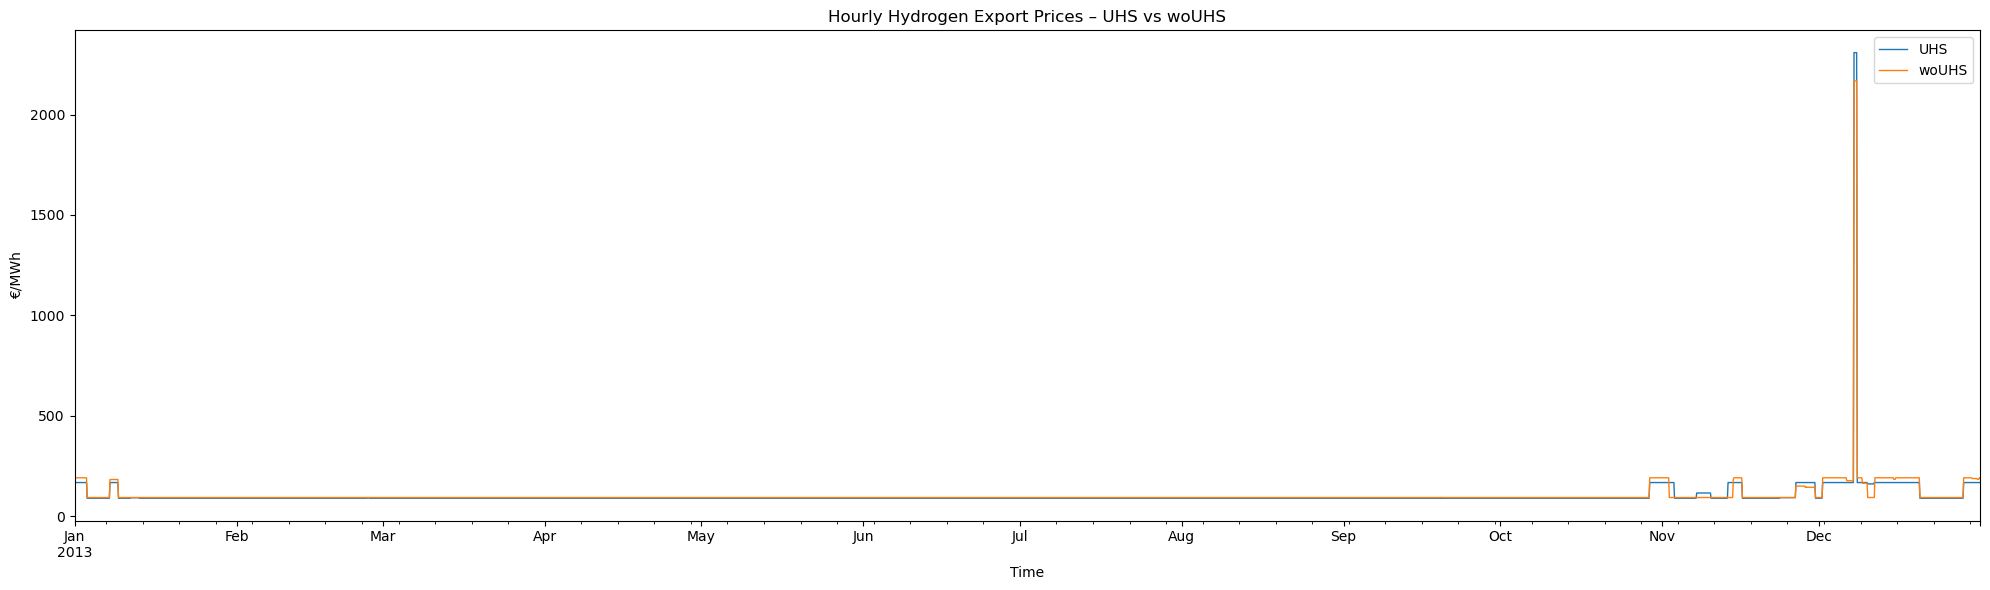

In [ ]:
def get_h2_export_prices(n: pypsa.Network):
    """
    Extract hourly marginal prices for the hydrogen export bus.
    Returns a pandas Series with time index.
    """
    h2_buses = n.buses[n.buses.index.str.contains("H2", case=False)].index
    prices = n.buses_t.marginal_price[h2_buses]
    if "H2 export bus" in prices.columns:
        return prices["H2 export bus"]
    else:
        export_cols = [c for c in prices.columns if "export" in c.lower()]
        return prices[export_cols[0]] if export_cols else None

#  Extract hourly prices 
uhs_export_prices = get_h2_export_prices(uhs)
woUHS_export_prices = get_h2_export_prices(woUHS)

#  Plot both on the same axis 
fig, ax = plt.subplots(figsize=(20, 6))

uhs_export_prices.plot(ax=ax, lw=1, color=SCENARIO_COLORS["UHS"], label="UHS")
woUHS_export_prices.plot(ax=ax, lw=1, color=SCENARIO_COLORS["woUHS"], label="woUHS")

ax.set_title("Hourly Hydrogen Export Prices – UHS vs woUHS")
ax.set_xlabel("Time")
ax.set_ylabel("€/MWh")
ax.legend()

plt.tight_layout()
plt.show()

##### Hourly Export Quantity

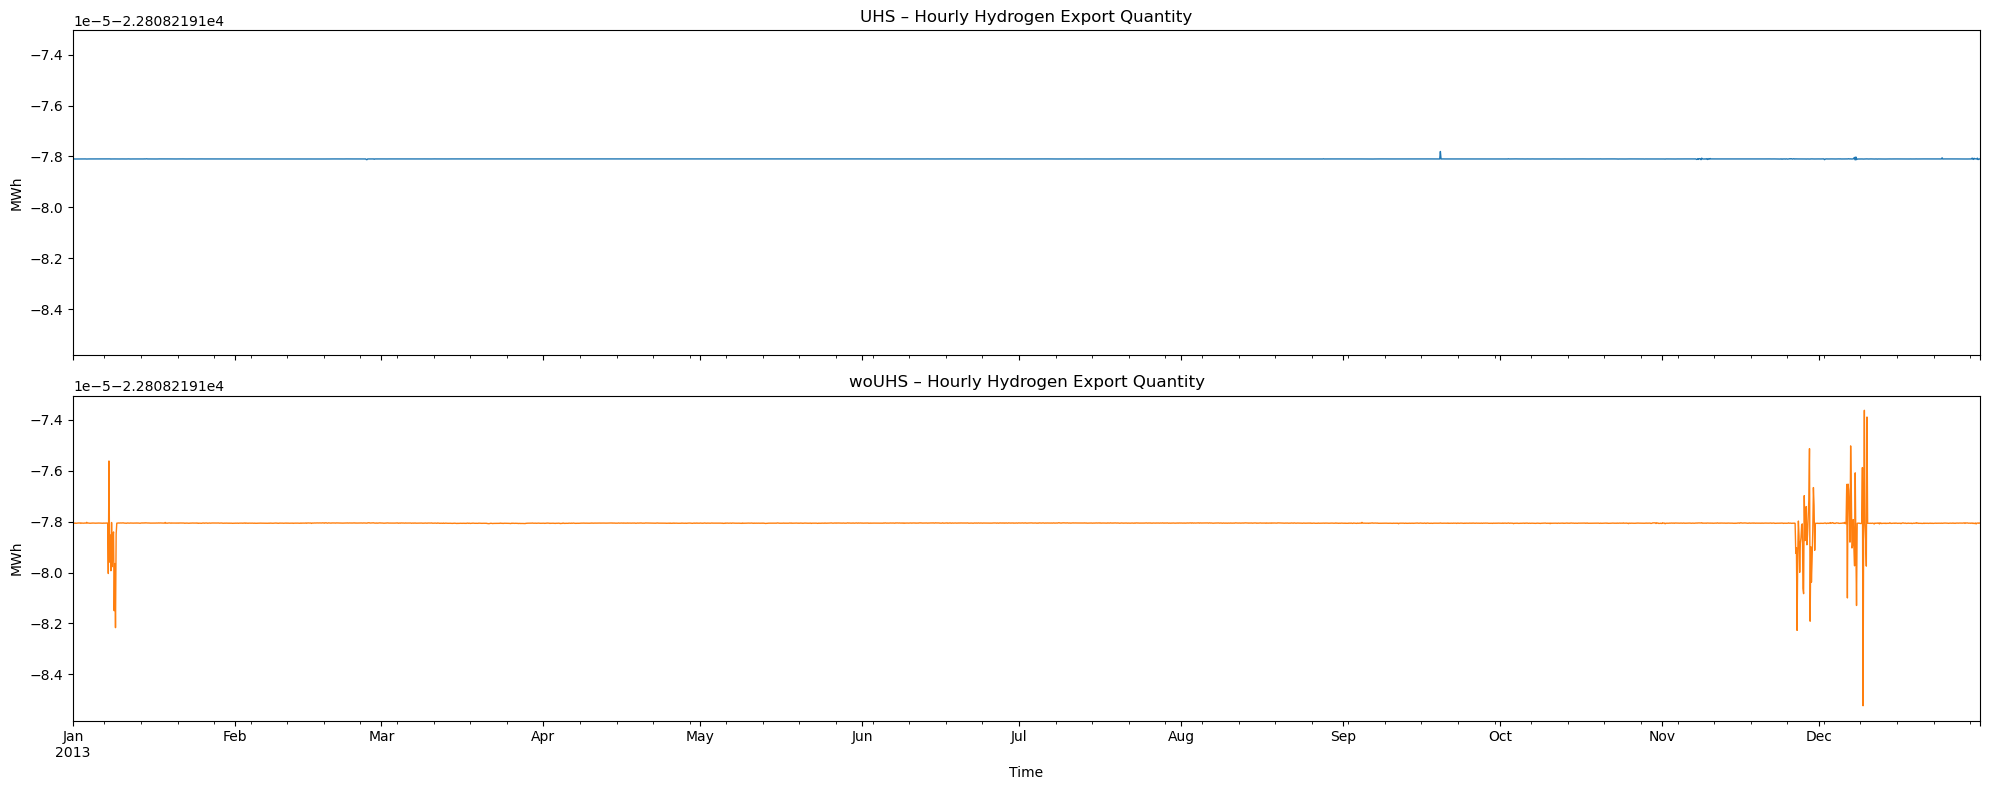

In [ ]:
def get_h2_export_quantity(n: pypsa.Network):
    """
    Extract aggregated hourly hydrogen export quantity from H2 export links.
    Returns a pandas Series (time-indexed).
    """
    # Filter hydrogen links
    h2_links = n.links[n.links["carrier"].str.contains("H2", case=False, na=False)]
    if h2_links.empty:
        return None

    h2_q = n.links_t.p1[h2_links.index].copy()

    # Identify columns that represent exports (adjust pattern if needed)
    export_cols = [col for col in h2_q.columns if "export" in col.lower()]
    if not export_cols:
        return None

    # Sum all export flows into one series
    h2_q["H2 export"] = h2_q[export_cols].sum(axis=1)
    return h2_q["H2 export"]

#  Extract export quantities 
uhs_export_q = get_h2_export_quantity(uhs)
woUHS_export_q = get_h2_export_quantity(woUHS)

#  Plot side-by-side 
fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True, sharey=True)

if uhs_export_q is not None:
    uhs_export_q.plot(ax=axes[0], lw=1, color=SCENARIO_COLORS["UHS"])
    axes[0].set_title("UHS – Hourly Hydrogen Export Quantity")
    axes[0].set_ylabel("MWh")

if woUHS_export_q is not None:
    woUHS_export_q.plot(ax=axes[1], lw=1, color=SCENARIO_COLORS["woUHS"])
    axes[1].set_title("woUHS – Hourly Hydrogen Export Quantity")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("MWh")

plt.tight_layout()
plt.show()

In [ ]:
# aggregate export quantitys to monthly sums and plot them for uhs and woUHS next to each other

In [ ]:
# Plot uhs storage levels over the year

In [ ]:
# plot hydrogen capacity for uhs and woUHS 2050 next to each other

##### Hourly Export Revenue

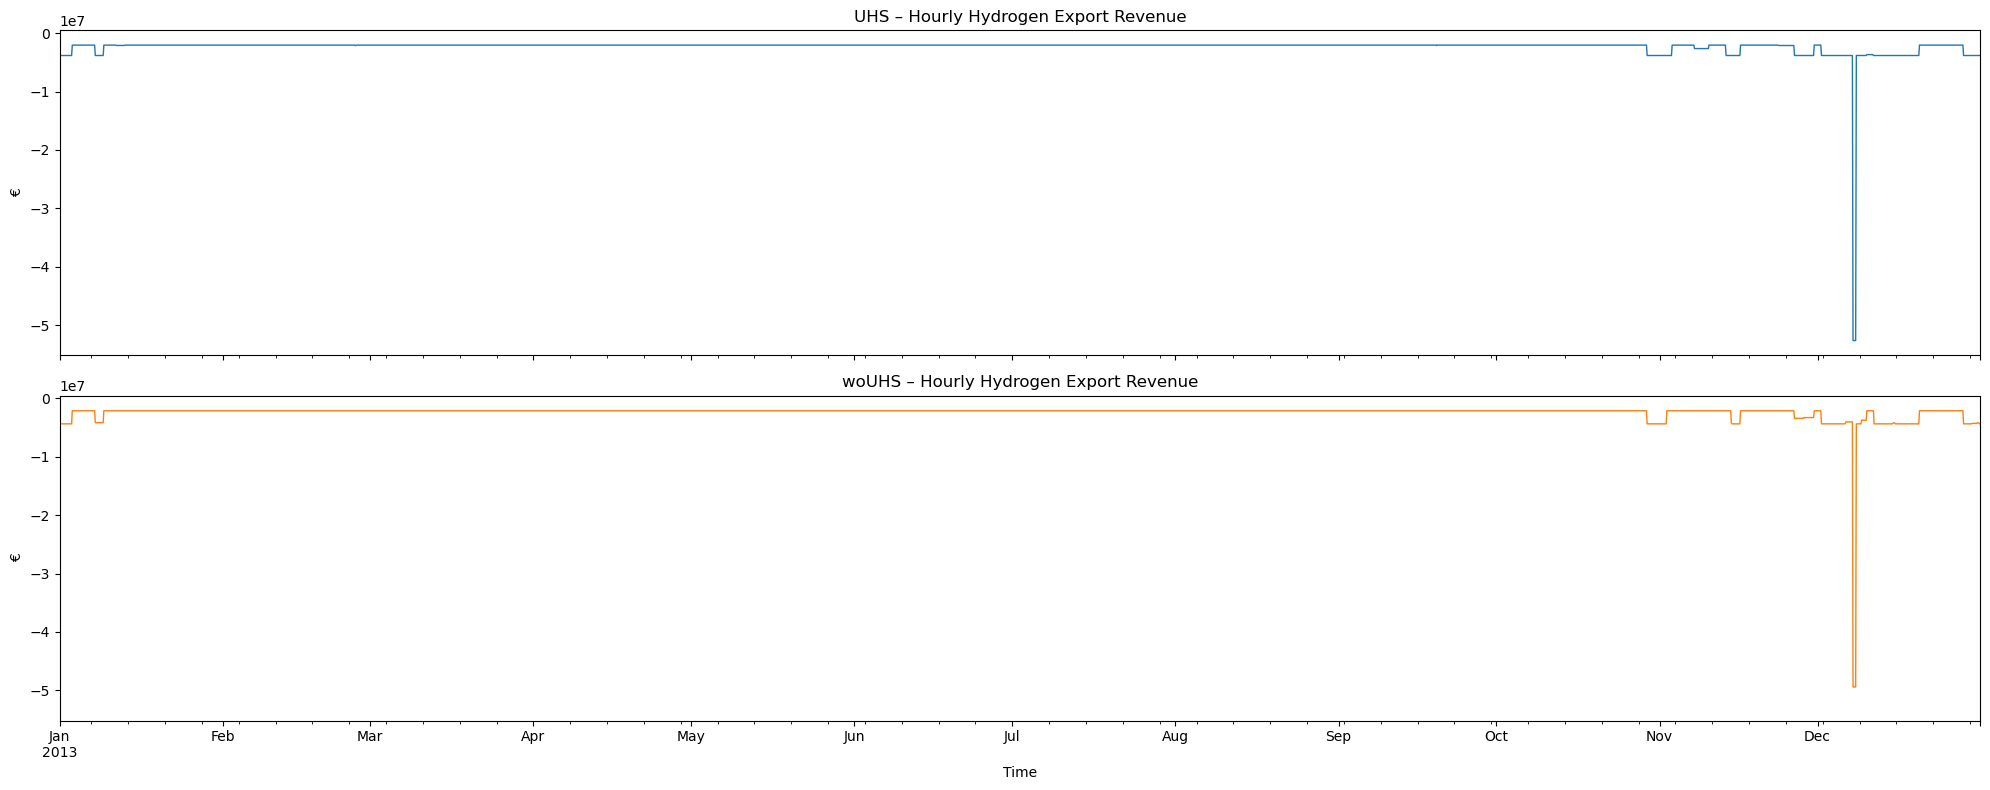

In [ ]:
def get_h2_export_prices(n: pypsa.Network) -> pd.Series | None:
    """
    Return hourly marginal prices (€/MWh) for the hydrogen export bus.
    """
    h2_buses = n.buses[n.buses.index.str.contains("H2", case=False, na=False)].index
    if len(h2_buses) == 0:
        return None

    prices = n.buses_t.marginal_price[h2_buses]
    if "H2 export bus" in prices.columns:
        return prices["H2 export bus"]
    # fallback: first H2 bus containing 'export'
    export_cols = [c for c in prices.columns if "export" in c.lower()]
    return prices[export_cols[0]] if export_cols else None

def get_h2_export_quantity(n: pypsa.Network) -> pd.Series | None:
    """
    Return aggregated hourly H2 export quantity (MWh) by summing all export links.
    """
    h2_links = n.links[n.links["carrier"].str.contains("H2", case=False, na=False)]
    if h2_links.empty:
        return None

    q = n.links_t.p1[h2_links.index].copy()
    export_cols = [c for c in q.columns if "export" in c.lower()]
    if not export_cols:
        return None

    q["H2 export"] = q[export_cols].sum(axis=1)
    return q["H2 export"]

def hourly_export_revenue(n: pypsa.Network) -> pd.Series | None:
    """
    Compute hourly export revenue (€) = quantity (MWh) * price (€/MWh).
    Aligns indices safely.
    """
    price = get_h2_export_prices(n)
    qty   = get_h2_export_quantity(n)
    if price is None or qty is None:
        return None

    # Align by intersection of timestamps; reindex quantity to price index like your workflow
    idx = price.index.intersection(qty.index)
    if len(idx) == 0:
        return None

    qty_aligned = qty.reindex(idx)
    price_aligned = price.reindex(idx)
    revenue = qty_aligned * price_aligned  # €
    revenue.name = "Hourly Revenue (€)"
    return revenue

# Compute hourly export revenue series
uhs_rev = hourly_export_revenue(uhs)
woUHS_rev = hourly_export_revenue(woUHS)

# Plot side-by-side 
fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True, sharey=True)

if uhs_rev is not None:
    uhs_rev.plot(ax=axes[0], lw=1, color=SCENARIO_COLORS["UHS"])
    axes[0].set_title("UHS – Hourly Hydrogen Export Revenue")
    axes[0].set_ylabel("€")

if woUHS_rev is not None:
    woUHS_rev.plot(ax=axes[1], lw=1, color=SCENARIO_COLORS["woUHS"])
    axes[1].set_title("woUHS – Hourly Hydrogen Export Revenue")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("€")

plt.tight_layout()
plt.show()

In [ ]:
# Show how hydrogen underground storage can both stabilize fluctuating hydrogen supply and better handle fluctuating demand (possibly with a graph showing supply/demand coverage with fluctuating supply and demand with/without hydrogen storage)

In [ ]:
# Show how storage can have a price-stabilizing effect on both sides (exporting/importing countries)

In [ ]:
# identify the LCOH of the deposits and investigating which ones have been selected

#### Show PV and Wind Potential

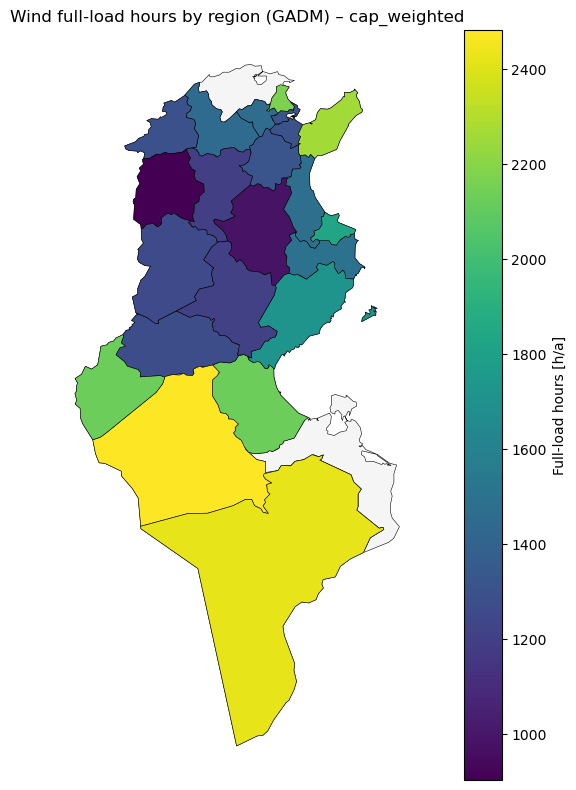

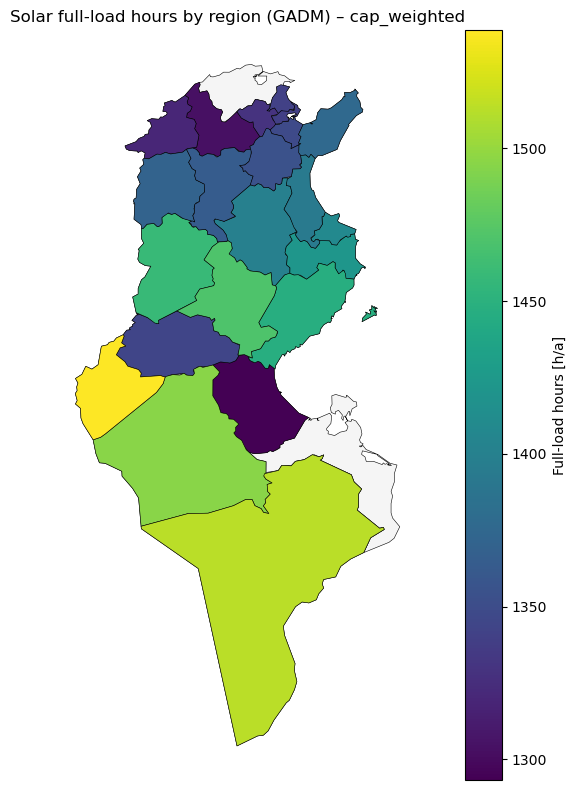

In [349]:
# ============================================================
# SETTINGS
# ============================================================

net = uhs

# Adjust carriers to your network naming
WIND_CARRIERS = ["onwind", "offwind-ac", "offwind-dc", "wind"]
SOLAR_CARRIERS = ["solar", "solar rooftop", "pv"]

# Choose how to aggregate multiple buses per polygon:
#   "mean"          -> simple average of bus FLH in the polygon
#   "cap_weighted"  -> capacity-weighted average (recommended)
AGG_METHOD = "cap_weighted"

# Optional: choose which polygon id/name column to show in titles / debugging
# If you don't know, set to None; code will still work.
REGION_NAME_COL = None  # e.g. "NAME_1" or "name" depending on your gadm_shapes

FIGSIZE = (10, 8)

# You must have:
#   gadm_shapes : GeoDataFrame with polygons, CRS EPSG:4326 (or will be converted)
# already loaded in your notebook.
# ============================================================


# ============================================================
# HELPERS
# ============================================================

def _snapshot_weights(net):
    if hasattr(net, "snapshot_weightings") and net.snapshot_weightings is not None:
        try:
            if "generators" in net.snapshot_weightings:
                return net.snapshot_weightings["generators"]
        except Exception:
            pass
    return pd.Series(1.0, index=net.snapshots)


def _bus_points_gdf(net):
    """Bus points as GeoDataFrame (EPSG:4326)."""
    buses = net.buses.copy()
    buses = buses.dropna(subset=["x", "y"])
    gdf = gpd.GeoDataFrame(
        buses,
        geometry=gpd.points_from_xy(buses["x"], buses["y"]),
        crs="EPSG:4326"
    )
    return gdf


def flh_by_bus(net, carriers):
    """
    Full-load hours per bus for given generator carriers:
      FLH_bus = sum(E_gen_bus) / sum(P_nom_bus)
    Returns:
      flh (Series indexed by bus)
      p_bus (Series indexed by bus) installed capacity [MW] used for weighting
    """
    w = _snapshot_weights(net)

    gens = net.generators.copy()
    gens = gens[gens.carrier.astype(str).isin(carriers)].copy()
    if gens.empty:
        return pd.Series(dtype=float), pd.Series(dtype=float)

    pnom_col = "p_nom_opt" if "p_nom_opt" in gens.columns else "p_nom"
    p_nom = gens[pnom_col].fillna(0.0)

    # Production time series [MW]
    p = net.generators_t.p[gens.index]
    e_mwh = (p.mul(w, axis=0)).sum(axis=0)  # MWh/a per generator

    # Aggregate to bus
    e_bus = e_mwh.groupby(gens["bus"]).sum()
    p_bus = p_nom.groupby(gens["bus"]).sum()

    flh = (e_bus / p_bus.replace(0.0, np.nan)).dropna()
    p_bus = p_bus.reindex(flh.index).fillna(0.0)

    return flh, p_bus


def aggregate_bus_metric_to_polygons(gadm_shapes, bus_gdf, metric_bus, weight_bus=None, agg_method="cap_weighted"):
    """
    Spatial join bus points -> polygons, then aggregate bus metric to polygon level.

    Returns a copy of gadm_shapes with new column 'value' (polygon-level metric).
    """
    # Ensure CRS match
    poly = gadm_shapes.copy()
    if poly.crs is None:
        poly = poly.set_crs("EPSG:4326")
    if bus_gdf.crs is None:
        bus_gdf = bus_gdf.set_crs("EPSG:4326")
    if poly.crs != bus_gdf.crs:
        bus_gdf = bus_gdf.to_crs(poly.crs)

    # Prepare bus dataframe for join
    b = bus_gdf.loc[metric_bus.index].copy()
    b["metric"] = metric_bus
    if weight_bus is not None:
        b["weight"] = weight_bus.reindex(metric_bus.index).fillna(0.0)
    else:
        b["weight"] = 1.0

    # Spatial join: assign each bus point to a polygon
    joined = gpd.sjoin(b[["metric", "weight", "geometry"]], poly, how="inner", predicate="within")
    # joined has index_right = polygon index
    if joined.empty:
        out = poly.copy()
        out["value"] = np.nan
        return out

    if agg_method == "mean":
        poly_val = joined.groupby("index_right")["metric"].mean()

    elif agg_method == "cap_weighted":
        # weighted mean: sum(metric*weight) / sum(weight)
        num = (joined["metric"] * joined["weight"]).groupby(joined["index_right"]).sum()
        den = joined["weight"].groupby(joined["index_right"]).sum().replace(0.0, np.nan)
        poly_val = (num / den)

    else:
        raise ValueError("agg_method must be 'mean' or 'cap_weighted'")

    out = poly.copy()
    out["value"] = poly_val.reindex(out.index)
    return out


def plot_polygon_map(gdf_polys, title, cmap="viridis"):
    fig, ax = plt.subplots(figsize=FIGSIZE)

    # Base polygons in light gray if NaN
    gdf_polys.plot(ax=ax, color="whitesmoke", edgecolor="black", linewidth=0.4)

    # Colored overlay where value exists
    gdf_polys.dropna(subset=["value"]).plot(
        ax=ax,
        column="value",
        cmap=cmap,
        legend=True,
        legend_kwds={"label": "Full-load hours [h/a]"},
        edgecolor="black",
        linewidth=0.4
    )

    ax.set_title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


# ============================================================
# RUN: WIND + SOLAR maps
# ============================================================

# 1) Prepare bus points once
bus_gdf = _bus_points_gdf(net)

# 2) WIND FLH per bus
wind_present = [c for c in WIND_CARRIERS if c in set(net.generators.carrier.astype(str).unique())]
if len(wind_present) == 0:
    print("No WIND carriers found. Available generator carriers:\n", net.generators.carrier.unique())
else:
    flh_wind, p_wind_bus = flh_by_bus(net, wind_present)
    wind_polys = aggregate_bus_metric_to_polygons(
        gadm_shapes, bus_gdf, flh_wind, weight_bus=p_wind_bus, agg_method=AGG_METHOD
    )
    plot_polygon_map(wind_polys, f"Wind full-load hours by region (GADM) – {AGG_METHOD}")

# 3) SOLAR FLH per bus
solar_present = [c for c in SOLAR_CARRIERS if c in set(net.generators.carrier.astype(str).unique())]
if len(solar_present) == 0:
    print("No SOLAR carriers found. Available generator carriers:\n", net.generators.carrier.unique())
else:
    flh_solar, p_solar_bus = flh_by_bus(net, solar_present)
    solar_polys = aggregate_bus_metric_to_polygons(
        gadm_shapes, bus_gdf, flh_solar, weight_bus=p_solar_bus, agg_method=AGG_METHOD
    )
    plot_polygon_map(solar_polys, f"Solar full-load hours by region (GADM) – {AGG_METHOD}")


In [ ]:
solar = xr.open_dataset(solar_path)
wind = xr.open_dataset(onwind_path)

def plot_voronoi(n, carrier, voronoi, cmap, projection, title=None, filename=None):
    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file(f"../../../pypsa-earth/resources/UHS/bus_regions/regions_{voronoi}.geojson").set_index("name")
    br_area = br.to_crs("ESRI:54009")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area

    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=br["p_nom_max"].max(),
        legend=True,
        legend_kwds={"label": r"potential density"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent(country_coordinates, crs=ccrs.PlateCarree()) 
    
    if title is not None:
        plt.title(title)

#### Wind potentials

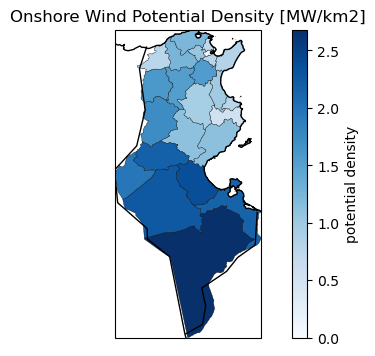

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
logging.getLogger("pypsa.io").setLevel(logging.ERROR)
plot_voronoi(
    pypsa.Network(network_path),
    "onwind",
    "onshore",
    "Blues",
    ccrs.PlateCarree(),
    title="Onshore Wind Potential Density [MW/km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)

#### Solar potentials

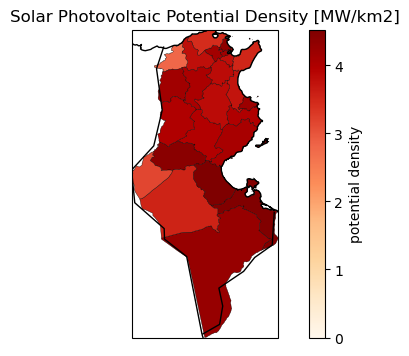

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
logging.getLogger("pypsa.io").setLevel(logging.ERROR)
plot_voronoi(
    pypsa.Network(network_path),
    "solar",
    "onshore",
    "OrRd",
    ccrs.PlateCarree(),
    title="Solar Photovoltaic Potential Density [MW/km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)

#### Sensitivity Analysis

In [ ]:
# Compare the use of underground hydrogen storage for UHS and woUHS 2050 with various spatial scenarios (1-10-24-100 nodes)

In [ ]:
# compare price stabilizing effect results with and without temporal matching activated